## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [3]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install pydantic==2.7.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 22.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
!pip install gensim

In [5]:
!pip install scipy==1.11.4

In [6]:
# pandas and numpy
import pandas as pd
import numpy as np
import spacy
# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim 
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:

from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE

In [8]:
# load data 
# ----------
congress_tweets = pd.read_csv("../../data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index()

In [9]:
np.random.seed(42)
congress_tweets_subset = congress_tweets.sample(5000)
congress_tweets_subset.head(60)

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
908961,908961,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,RT @RepKClark 22 million Americans filed for u...,Pramila Jayapal,Rep,3-Jan-17,9/21/1965,F,WA,7,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670"
175615,175615,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum ...,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,1,Democrat,"673,215","897,572","905,083","634,892"
64613,64613,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Nancy Pelosi,Rep,2-Jun-87,3/26/1940,F,CA,12,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
783091,783091,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Joaquín Castro,Rep,3-Jan-13,9/16/1974,M,TX,20,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843"
553399,553399,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today ...,Joseph D. Morelle,Rep,13-Nov-18,4/29/1957,M,NY,25,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"
32238,32238,1.250890e+18,RepGregStanton,2020-04-16T17:06:29-04:00,.@RepRubenGallego and I are urging companies w...,Greg Stanton,Rep,3-Jan-19,3/8/1970,M,AZ,9,Democrat,"1,252,401","1,161,167","1,025,232","1,233,654"
20570,20570,1.180130e+18,RepAndyBiggsAZ,2019-10-04T10:38:19-04:00,"Another month, another jobs report, showing th...",Andy Biggs,Rep,3-Jan-17,11/7/1958,M,AZ,5,Republican,"1,252,401","1,161,167","1,025,232","1,233,654"
704089,704089,1.286440e+18,RepDwightEvans,2020-07-23T19:15:21-04:00,RT @eyokley NEW: Police reform debate paints a...,Dwight Evans,Rep,14-Nov-16,5/16/1954,M,PA,3,Democrat,"2,970,733","2,926,441","2,990,274","2,680,434"
246925,246925,1.292220e+18,RepDMP,2020-08-08T18:02:19-04:00,"This order cuts unemployment, abandons our loc...",Debbie Mucarsel-Powell,Rep,3-Jan-19,1/18/1971,F,FL,26,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"
267417,267417,1.092890e+18,CongMikeSimpson,2019-02-05T15:48:48-05:00,RT @RepRussFulcher January reports show amazin...,Mike Simpson,Rep,3-Jan-99,9/8/1950,M,ID,2,Republican,"409,055","189,765","212,787","420,911"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [12]:
congress_tweets_subset['text'].head

<bound method NDFrame.head of 908961    RT @RepKClark 22 million Americans filed for u...
175615    Thanks to all who came out to tonight’s forum ...
64613     RT @RepFilemonVela #Dreamers &amp; TPS recipie...
783091    RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...
553399    Thank you to @NYGovCuomo for being here today ...
                                ...                        
191471    RT @SenatorBraun May is officially #ALSAwarene...
260884    Powerful words today from my friend and collea...
11727     RT @Ch2KTUU Alaska Senator Dan Sullivan said h...
356261    Open the schools. https://twitter.com/kyoag/st...
302981    Great news for @ConnectTransit! This week, @Ro...
Name: text, Length: 5000, dtype: object>

In [13]:
tweets = congress_tweets_subset['text'][783091]
tweets

'RT @HispanicCaucus @JoaquinCastrotx @TheBlackCaucus @CAPAC @ExpressScripts @OptumRx @UnitedHealthGrp These CEOS represent 2 of the largest Pharmacy Benefit Managers (PBMs) in the US and are key players in the rising cost of insulin. We are hoping for a productive discussion as we all work to ensure that Americans have the #insulin they need at affordable prices. #Insulin4All'

In [14]:
sentences = tweets.split(".")
sentences

['RT @HispanicCaucus @JoaquinCastrotx @TheBlackCaucus @CAPAC @ExpressScripts @OptumRx @UnitedHealthGrp These CEOS represent 2 of the largest Pharmacy Benefit Managers (PBMs) in the US and are key players in the rising cost of insulin',
 ' We are hoping for a productive discussion as we all work to ensure that Americans have the #insulin they need at affordable prices',
 ' #Insulin4All']

In [15]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    nlp.Defaults.stop_words |= {"http://", "https://","RT","\n","\n\xa0\n","\n\n", "QT","amp", "rt","qt", "\n\n#"}
    
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]

    spacy_words = [word for word in spacy_words if not word.startswith('https')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [16]:
print(STOP_WORDS)

{'my', 'onto', 'anyhow', 'upon', 'then', 'last', 'another', 'put', 'seeming', 'beforehand', 'them', 'up', 'sometimes', 'it', 'only', 'yourselves', 'to', 'nevertheless', 'via', 'a', 'most', 'she', 'some', 'how', 'before', 'very', 'hers', 'quite', 'next', 'the', 'somewhere', 'too', 'whose', 'here', 'you', '‘d', 'did', 'us', 'in', 'ten', 'herein', 'two', 'again', 'will', 'often', 'indeed', 'behind', 'n’t', 'except', 'within', 'since', 'at', 'get', 'sometime', 'anywhere', 'much', '‘m', 'mine', 'such', 'full', 'used', 'during', 'an', 'but', 'whether', 'were', 'which', 'various', 'however', 'ourselves', 'this', 'third', 'give', 'less', 'meanwhile', 'beside', 'unless', 'those', 'five', 'hereby', 'regarding', 'against', 'say', 'ours', 'we', 'latterly', 'front', 'hereupon', 'until', 'are', 'mostly', 'whereas', 'between', 'go', 'latter', 'not', 'out', 'afterwards', 'part', 'as', 'yourself', 'of', 'thereby', 'he', "'ve", 'may', 'back', 'should', 'below', 'besides', 'least', 'further', 'otherwise'

In [17]:
print(len(STOP_WORDS))

326


In [18]:
congress_tweets_subset['tokens'] = congress_tweets_subset['text'].map(lambda x: rem_punc_stop(x)) # can use apply here apply() pd specific and map() base in tidyverse 
congress_tweets_subset['tokens'] # visualize

908961    [RepKClark, 22, million, Americans, filed, une...
175615            [Thanks, came, tonight, forum, GOPTaxLaw]
64613     [RepFilemonVela, Dreamers, TPS, recipients, es...
783091    [HispanicCaucus, JoaquinCastrotx, TheBlackCauc...
553399    [Thank, NYGovCuomo, today, face, extreme, weat...
                                ...                        
191471    [SenatorBraun, May, officially, ALSAwarenessMo...
260884    [Powerful, words, today, friend, colleague, Se...
11727     [Ch2KTUU, Alaska, Senator, Dan, Sullivan, said...
356261    [Open, schools, kyoag, Today, 38, US, Senators...
302981    [Great, news, ConnectTransit, This, week, Rodn...
Name: tokens, Length: 5000, dtype: object

In [19]:
congress_tweets_subset['tokens'][356261]
#Tokens removed include URL links, indications of Retweets and qouted tweets  which includes RT & QT, 
#and also removed /n/n which I am unsure what this might be alluding to in the textual corpus 

['Open',
 'schools',
 'kyoag',
 'Today',
 '38',
 'US',
 'Senators',
 'including',
 'senatemajldr',
 'randpaul',
 'filed',
 'amicus',
 'brief',
 'SCOTUS',
 'supporting',
 'fight',
 'stop',
 'Governor',
 'infringing',
 'First',
 'Amendment',
 'rights',
 'Kentuckians',
 'closing',
 'religious',
 'schools',
 'Read',
 'brief']

In [20]:
congress_tweets_subset[['tokens','text']]

,tokens,text
908961,"[RepKClark, 22, million, Americans, filed, une...",RT @RepKClark 22 million Americans filed for u...
175615,"[Thanks, came, tonight, forum, GOPTaxLaw]",Thanks to all who came out to tonight’s forum ...
64613,"[RepFilemonVela, Dreamers, TPS, recipients, es...",RT @RepFilemonVela #Dreamers &amp; TPS recipie...
783091,"[HispanicCaucus, JoaquinCastrotx, TheBlackCauc...",RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...
553399,"[Thank, NYGovCuomo, today, face, extreme, weat...",Thank you to @NYGovCuomo for being here today ...
...,...,...
191471,"[SenatorBraun, May, officially, ALSAwarenessMo...",RT @SenatorBraun May is officially #ALSAwarene...
260884,"[Powerful, words, today, friend, colleague, Se...",Powerful words today from my friend and collea...
11727,"[Ch2KTUU, Alaska, Senator, Dan, Sullivan, said...",RT @Ch2KTUU Alaska Senator Dan Sullivan said h...
356261,"[Open, schools, kyoag, Today, 38, US, Senators...",Open the schools. https://twitter.com/kyoag/st...


## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1

In [24]:
!pip install scattertext
!pip install wordcloud
!pip install textblob

In [25]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
import matplotlib.pyplot as plt


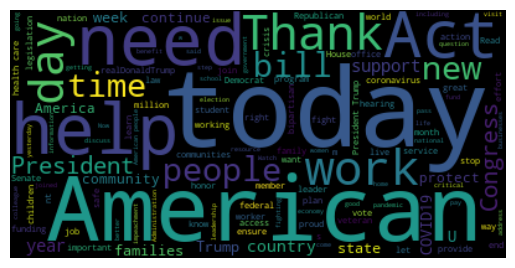

In [26]:
# apply function to text object; created a text object 
text = ' '.join(congress_tweets_subset['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(random_state=40).generate(text) # set random state to ensure same word cloud each time; random seed 

# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()      
# interestingly words like American, today, families,  Work, support, and President, COVID-19 has higher frequency in this textual corpus. 

### EDA 2

In [28]:
# create new feature columns with counts of # of characters and # of words
# ----------

# count number of characters
congress_tweets_subset['tweet_len'] = congress_tweets_subset['text'].apply(len)

# count number of words
congress_tweets_subset['tweet_word_count'] = congress_tweets_subset['text'].apply(lambda x: len(str(x).split()))

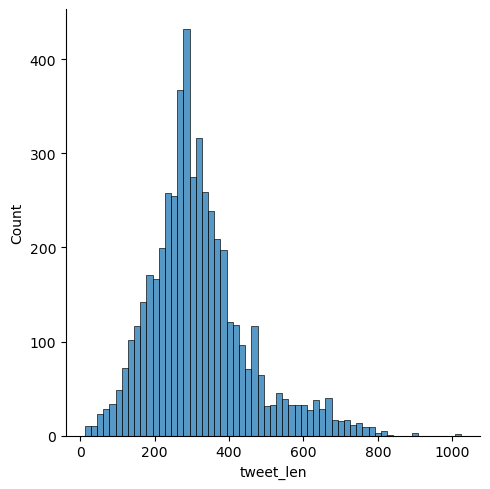

In [29]:
# create histogram of complaint length (number of characters)
sns.displot(congress_tweets_subset,              # specify data
            x="tweet_len") # x-axis feature
plt.show() # distribution of word character count is skewed but perhaps due to the limit on word characters that exist on twitter/X

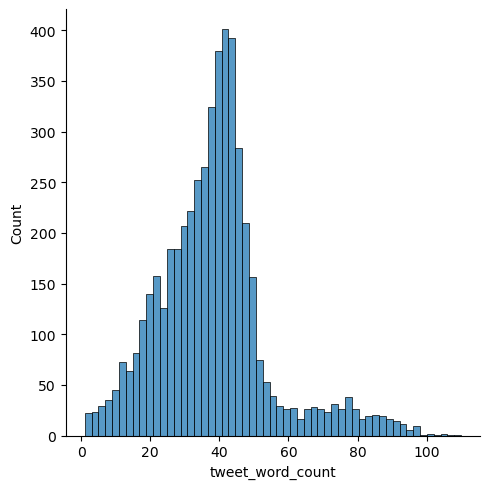

In [30]:
# create histogram of word count
sns.displot(congress_tweets_subset,           # specify data 
            x="tweet_word_count") # x-axis feature
plt.show() # 

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

## Examining the Polarity and Subjectivity of tweets made by Rep Barbara Lee (D) and Rep Chip Roy (R)

In [34]:
congress_legislators_subset = congress_tweets_subset[['tokens','text','name_wikipedia']] # Barbara Lee and Chip Roy

In [35]:
congress_legislators_subset.head(10)

,tokens,text,name_wikipedia
908961,"[RepKClark, 22, million, Americans, filed, une...",RT @RepKClark 22 million Americans filed for u...,Pramila Jayapal
175615,"[Thanks, came, tonight, forum, GOPTaxLaw]",Thanks to all who came out to tonight’s forum ...,John B. Larson
64613,"[RepFilemonVela, Dreamers, TPS, recipients, es...",RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Nancy Pelosi
783091,"[HispanicCaucus, JoaquinCastrotx, TheBlackCauc...",RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Joaquín Castro
553399,"[Thank, NYGovCuomo, today, face, extreme, weat...",Thank you to @NYGovCuomo for being here today ...,Joseph D. Morelle
32238,"[RepRubenGallego, I, urging, companies, supply...",.@RepRubenGallego and I are urging companies w...,Greg Stanton
20570,"[Another, month, jobs, report, showing, POTUS,...","Another month, another jobs report, showing th...",Andy Biggs
704089,"[eyokley, NEW, Police, reform, debate, paints,...",RT @eyokley NEW: Police reform debate paints a...,Dwight Evans
246925,"[This, order, cuts, unemployment, abandons, lo...","This order cuts unemployment, abandons our loc...",Debbie Mucarsel-Powell
267417,"[RepRussFulcher, January, reports, amazing, pr...",RT @RepRussFulcher January reports show amazin...,Mike Simpson


In [36]:
specific_names = "Chip Roy"  # Change this to the desired name

# Filter all rows where 'name_wikipedia' matches the specific name
congress_legislator_roy = congress_legislators_subset.loc[
    congress_legislators_subset['name_wikipedia'] == specific_names, 
    ['tokens', 'text', 'name_wikipedia']
]
congress_legislator_roy

,tokens,text,name_wikipedia
808493,"[Despite, knowledge, dangerous, virus, Dr, Wen...",Despite being one of the first to have knowled...,Chip Roy
792023,"[What, hearing, news, today, Whatever, , I, g...",What are you hearing about in the news today? ...,Chip Roy
788311,"[When, pastures, green, springtime, And, birds...",When the pastures are green in the springtime\...,Chip Roy
809238,"[Small, businesses, workers, employ, fabric, H...",Small businesses and the workers they employ a...,Chip Roy
763660,"[ExpressNews, A, march, fallen, heroes, starts...",RT @ExpressNews A march for fallen heroes star...,Chip Roy
786115,"[This, heinous, crime, prevented, EsquivelGarc...",This heinous crime could have been prevented. ...,Chip Roy
815273,"[But, rules, House, limit, virtually, action, ...","But, the rules of the House limit virtually al...",Chip Roy
764027,"[LoriRMixson, RepChipRoy, blazevszipper, 🙌, 🙌,...",RT @LoriRMixson @RepChipRoy @blazevszipper 🙌🙌🙌...,Chip Roy
795491,"[He, mastermind, brutal, attacks, important, a...",He was the mastermind of many brutal attacks a...,Chip Roy
831521,"[YALiberty, RepChipRoy, GOES, OFF, Congress, p...",RT @YALiberty .@RepChipRoy GOES OFF on Congres...,Chip Roy


In [37]:
# Define the specific name
specific_name = "Barbara Lee"  # Change this to the desired name

# Filter all rows where 'name_wikipedia' matches the specific name
congress_legislator_lee = congress_legislators_subset.loc[
congress_legislators_subset['name_wikipedia'] == specific_name, 
    ['tokens', 'text', 'name_wikipedia']
]

# Display the subset
congress_legislator_lee

,tokens,text,name_wikipedia
68126,"[I, believe, KeepFamiliesTogether, controversi...",I can’t believe that #KeepFamiliesTogether is ...,Barbara Lee
69582,"[OfficialCBC, Three, bills, introduced, RepBar...",RT @OfficialCBC Three bills have been introduc...,Barbara Lee
130873,"[I, mean, pass, HeroesAct, s, sitting, Mitch, ...","I mean, you could just... pass the #HeroesAct ...",Barbara Lee
83950,"[Trumps, cruel, proposal, hurt, millions, fami...",Trump's cruel proposal would hurt millions of ...,Barbara Lee
153462,"[When, Mitch, McConnell, demands, liability, p...",When Mitch McConnell demands liability protect...,Barbara Lee
68815,"[In, past, month, Trump, proposed, budget, sla...","In the past month alone, Trump proposed a budg...",Barbara Lee
96802,"[Trump, pressure, campaign, undermined, democr...",Trump’s pressure campaign undermined our own d...,Barbara Lee
135751,"[We, dismantle, systems, hate, oppression, cou...",We must dismantle the systems of hate and oppr...,Barbara Lee
119859,"[AppropsDems, Need, proof, President, Trumps, ...",RT @AppropsDems Need more proof that President...,Barbara Lee
147230,"[Avoiding, federal, income, taxes, “, smart, ”...","Avoiding federal income taxes isn’t “smart,” i...",Barbara Lee


In [38]:
# create the "tokens" column again 
congress_legislator_roy['tokens'] = congress_legislator_roy['tokens'].map(lambda text: ' '.join(text))

# create the "polarity" column again 
congress_legislator_roy['polarity'] = congress_legislator_roy['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)


In [39]:
congress_legislator_roy.head(10)

,tokens,text,name_wikipedia,polarity
808493,Despite knowledge dangerous virus Dr Wenliang ...,Despite being one of the first to have knowled...,Chip Roy,-0.200000
792023,What hearing news today Whatever I guarantee...,What are you hearing about in the news today? ...,Chip Roy,0.000000
788311,When pastures green springtime And birds singi...,When the pastures are green in the springtime\...,Chip Roy,0.150000
809238,Small businesses workers employ fabric Hill Co...,Small businesses and the workers they employ a...,Chip Roy,-0.016667
763660,ExpressNews A march fallen heroes starts San A...,RT @ExpressNews A march for fallen heroes star...,Chip Roy,0.000000
786115,This heinous crime prevented EsquivelGarcia co...,This heinous crime could have been prevented. ...,Chip Roy,0.100000
815273,But rules House limit virtually action debate ...,"But, the rules of the House limit virtually al...",Chip Roy,0.289583
764027,LoriRMixson RepChipRoy blazevszipper 🙌 🙌 🙌 🙌 🙌...,RT @LoriRMixson @RepChipRoy @blazevszipper 🙌🙌🙌...,Chip Roy,0.278571
795491,He mastermind brutal attacks important allies ...,He was the mastermind of many brutal attacks a...,Chip Roy,-0.237500
831521,YALiberty RepChipRoy GOES OFF Congress passing...,RT @YALiberty .@RepChipRoy GOES OFF on Congres...,Chip Roy,-0.250000


In [40]:
# create the "tokens" column again 
congress_legislator_lee['tokens'] = congress_legislator_lee['tokens'].map(lambda text: ' '.join(text))

# create the "polarity" column again 
congress_legislator_lee['polarity'] = congress_legislator_lee['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)


In [41]:
congress_legislator_lee.head(10)

,tokens,text,name_wikipedia,polarity
68126,I believe KeepFamiliesTogether controversial o...,I can’t believe that #KeepFamiliesTogether is ...,Barbara Lee,0.550000
69582,OfficialCBC Three bills introduced RepBarbaraL...,RT @OfficialCBC Three bills have been introduc...,Barbara Lee,0.000000
130873,I mean pass HeroesAct s sitting Mitch McConnel...,"I mean, you could just... pass the #HeroesAct ...",Barbara Lee,-0.312500
83950,Trumps cruel proposal hurt millions families c...,Trump's cruel proposal would hurt millions of ...,Barbara Lee,-1.000000
153462,When Mitch McConnell demands liability protect...,When Mitch McConnell demands liability protect...,Barbara Lee,0.300000
68815,In past month Trump proposed budget slashes fu...,"In the past month alone, Trump proposed a budg...",Barbara Lee,-0.150000
96802,Trump pressure campaign undermined democracy u...,Trump’s pressure campaign undermined our own d...,Barbara Lee,0.100000
135751,We dismantle systems hate oppression country p...,We must dismantle the systems of hate and oppr...,Barbara Lee,-0.800000
119859,AppropsDems Need proof President Trumps illega...,RT @AppropsDems Need more proof that President...,Barbara Lee,-0.250000
147230,Avoiding federal income taxes “ smart ” betray...,"Avoiding federal income taxes isn’t “smart,” i...",Barbara Lee,0.214286


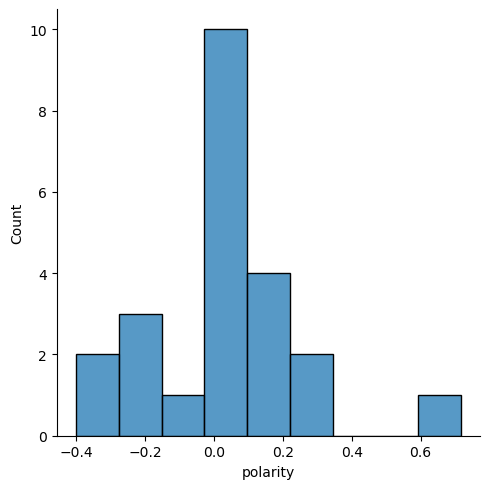

In [42]:
sns.displot(congress_legislator_roy,         # specify data
            x="polarity") # x-axis label 
plt.show()
## Polarity graph for Rep Chip Roy (R) reveal that his tweets are more often to be viewed as neutral 

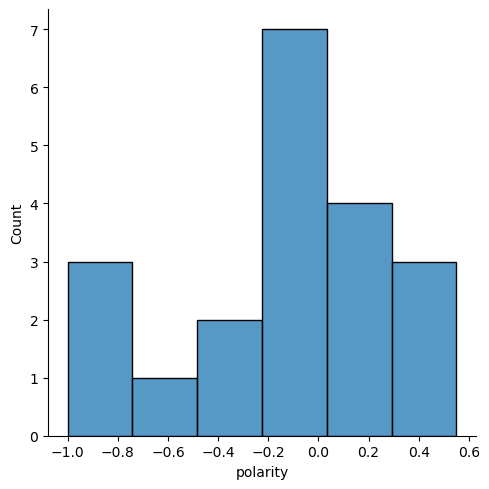

In [43]:
sns.displot(congress_legislator_lee,         # specify data
            x="polarity") # x-axis label 
plt.show()
#Polarity graph for Rep Barabara Lee (D) reveal that his tweets are more often to be viewed as neutral and slightly more positive than Bill floress 

In [44]:
# create new column feature of subjectivity
congress_legislator_roy['subjectivity'] =  congress_legislator_roy['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)


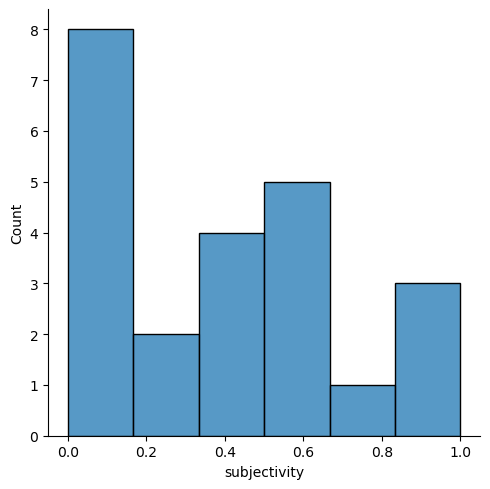

In [45]:
# plot
sns.displot(congress_legislator_roy,             # specify data
            x="subjectivity") # specify x-axis feature
plt.show()

In [46]:
congress_legislator_lee['subjectivity'] =  congress_legislator_lee['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

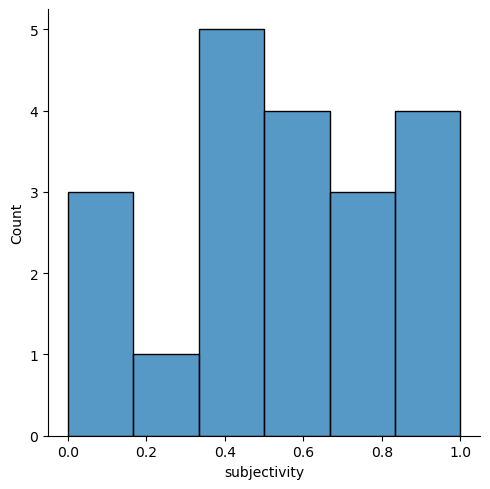

In [47]:

# plot
sns.displot(congress_legislator_lee,             # specify data
            x="subjectivity") # specify x-axis feature
plt.show()
#For Rep Barbara lee we get sentiment more centered around 0.4. 

## Democrat vs Republican Sentiment analysis. Examines polarity scores and subjectivity of each party 

In [49]:
congress_party_subset = congress_tweets_subset[['tokens','text','party']]

In [50]:
congress_party_subset.head(10)

,tokens,text,party
908961,"[RepKClark, 22, million, Americans, filed, une...",RT @RepKClark 22 million Americans filed for u...,Democrat
175615,"[Thanks, came, tonight, forum, GOPTaxLaw]",Thanks to all who came out to tonight’s forum ...,Democrat
64613,"[RepFilemonVela, Dreamers, TPS, recipients, es...",RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Democrat
783091,"[HispanicCaucus, JoaquinCastrotx, TheBlackCauc...",RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Democrat
553399,"[Thank, NYGovCuomo, today, face, extreme, weat...",Thank you to @NYGovCuomo for being here today ...,Democrat
32238,"[RepRubenGallego, I, urging, companies, supply...",.@RepRubenGallego and I are urging companies w...,Democrat
20570,"[Another, month, jobs, report, showing, POTUS,...","Another month, another jobs report, showing th...",Republican
704089,"[eyokley, NEW, Police, reform, debate, paints,...",RT @eyokley NEW: Police reform debate paints a...,Democrat
246925,"[This, order, cuts, unemployment, abandons, lo...","This order cuts unemployment, abandons our loc...",Democrat
267417,"[RepRussFulcher, January, reports, amazing, pr...",RT @RepRussFulcher January reports show amazin...,Republican


In [51]:
# create the "tokens" column again 
congress_party_subset['tokens'] = congress_party_subset['tokens'].map(lambda text: ' '.join(text))

# create the "polarity" column again 
congress_party_subset['polarity'] = congress_party_subset['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)


/var/folders/yx/f3mndt3d7tbg3g_q0clrd7700000gn/T/ipykernel_398/1377537319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  congress_party_subset['tokens'] = congress_party_subset['tokens'].map(lambda text: ' '.join(text))
/var/folders/yx/f3mndt3d7tbg3g_q0clrd7700000gn/T/ipykernel_398/1377537319.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  congress_party_subset['polarity'] = congress_party_subset['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)


In [52]:
congress_party_subset

,tokens,text,party,polarity
908961,RepKClark 22 million Americans filed unemploym...,RT @RepKClark 22 million Americans filed for u...,Democrat,0.350000
175615,Thanks came tonight forum GOPTaxLaw,Thanks to all who came out to tonight’s forum ...,Democrat,0.200000
64613,RepFilemonVela Dreamers TPS recipients essenti...,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Democrat,0.000000
783091,HispanicCaucus JoaquinCastrotx TheBlackCaucus ...,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Democrat,0.000000
553399,Thank NYGovCuomo today face extreme weather sy...,Thank you to @NYGovCuomo for being here today ...,Democrat,0.208333
...,...,...,...,...
191471,SenatorBraun May officially ALSAwarenessMonth ...,RT @SenatorBraun May is officially #ALSAwarene...,Democrat,0.500000
260884,Powerful words today friend colleague SenatorI...,Powerful words today from my friend and collea...,Republican,0.775000
11727,Ch2KTUU Alaska Senator Dan Sullivan said urged...,RT @Ch2KTUU Alaska Senator Dan Sullivan said h...,Republican,0.050000
356261,Open schools kyoag Today 38 US Senators includ...,Open the schools. https://twitter.com/kyoag/st...,Republican,0.083333


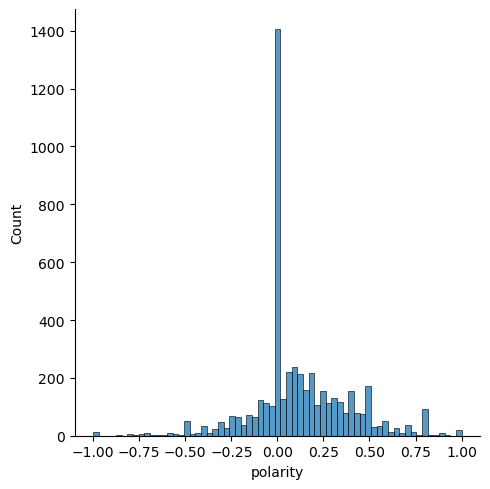

In [53]:
sns.displot(congress_party_subset,         # specify data
            x="polarity") # x-axis label 
plt.show()

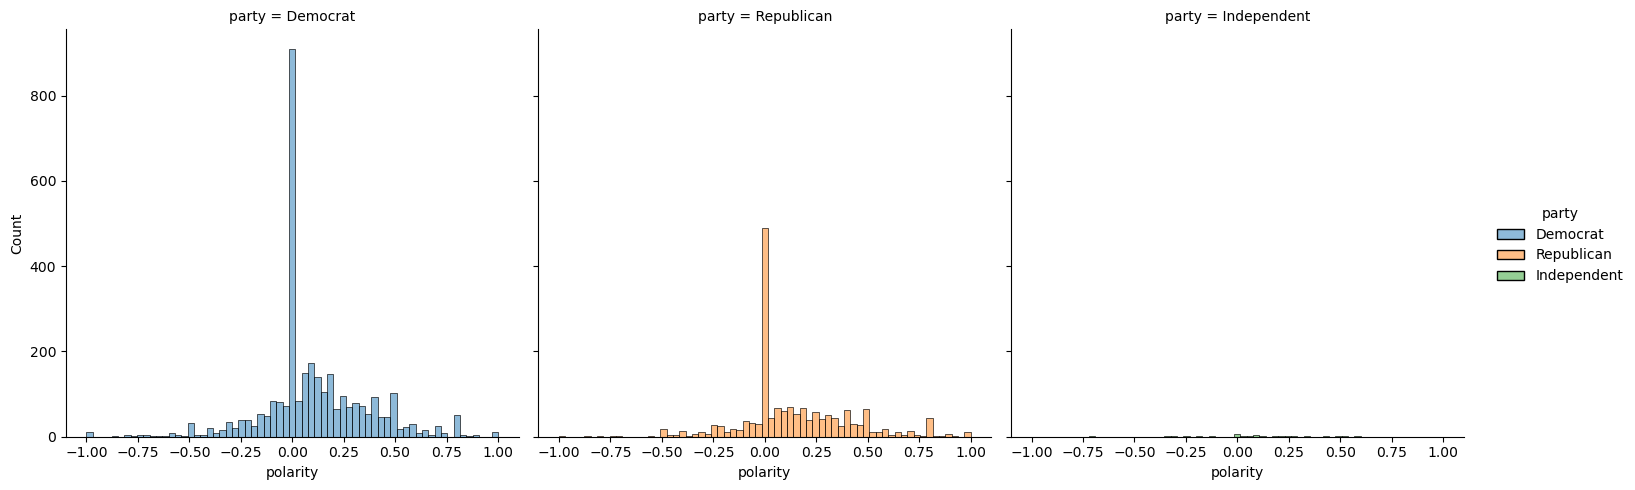

In [54]:
sns.displot(congress_party_subset,             # specify data
            x="polarity",   # x-axis feature
            hue = "party",  # color by party
            col = "party")  # color by party
plt.show()

In [55]:
congress_party_subset['subjectivity'] =  congress_party_subset['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

/var/folders/yx/f3mndt3d7tbg3g_q0clrd7700000gn/T/ipykernel_398/2577308592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  congress_party_subset['subjectivity'] =  congress_party_subset['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)


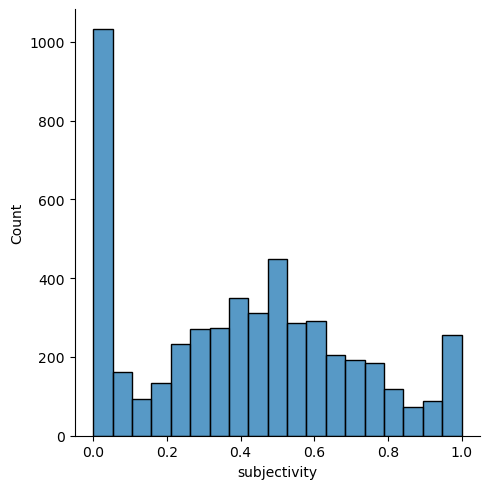

In [56]:
# plot
sns.displot(congress_party_subset,             # specify data
            x="subjectivity") # specify x-axis feature
plt.show()
#FThe democratic party have... 

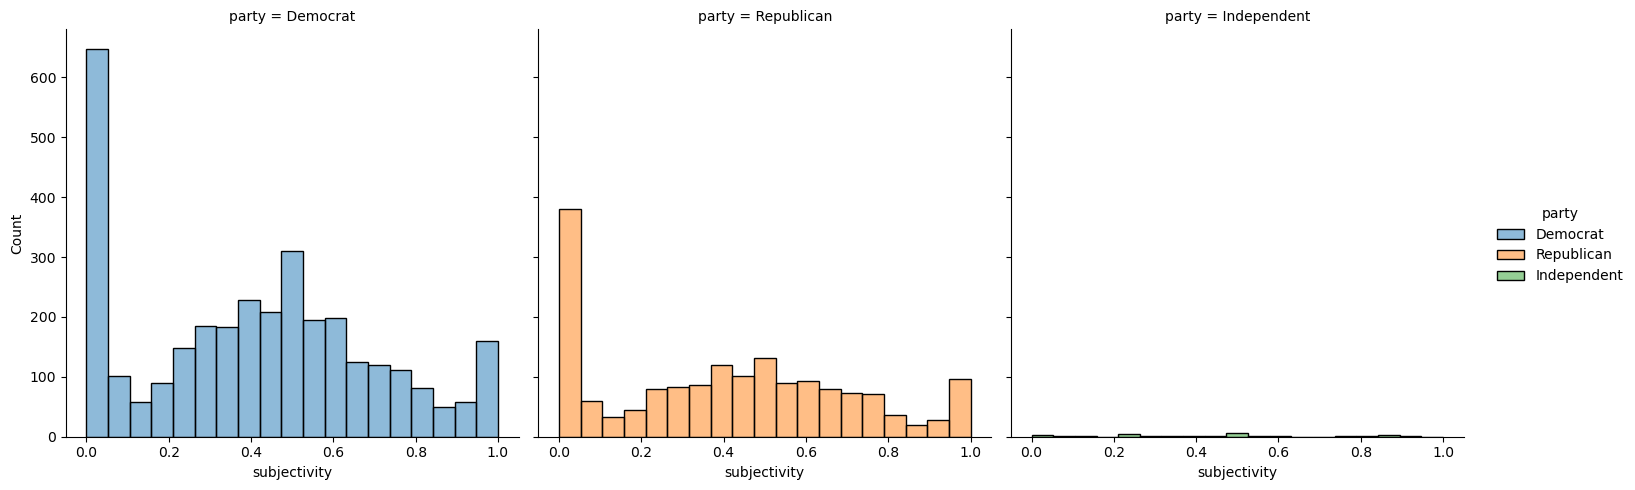

In [57]:
sns.displot(congress_party_subset,             # specify data
            x="subjectivity",   # x-axis feature
            hue = "party",  # color by by party
            col = "party")  # color by by party
plt.show()

## Examines the polarity and subjectivity made by Senators vs Representatives 

In [59]:
congress_position_subset = congress_tweets_subset[['tokens','text','position']] 

In [60]:
congress_position_subset.head(15)

,tokens,text,position
908961,"[RepKClark, 22, million, Americans, filed, une...",RT @RepKClark 22 million Americans filed for u...,Rep
175615,"[Thanks, came, tonight, forum, GOPTaxLaw]",Thanks to all who came out to tonight’s forum ...,Rep
64613,"[RepFilemonVela, Dreamers, TPS, recipients, es...",RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Rep
783091,"[HispanicCaucus, JoaquinCastrotx, TheBlackCauc...",RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Rep
553399,"[Thank, NYGovCuomo, today, face, extreme, weat...",Thank you to @NYGovCuomo for being here today ...,Rep
32238,"[RepRubenGallego, I, urging, companies, supply...",.@RepRubenGallego and I are urging companies w...,Rep
20570,"[Another, month, jobs, report, showing, POTUS,...","Another month, another jobs report, showing th...",Rep
704089,"[eyokley, NEW, Police, reform, debate, paints,...",RT @eyokley NEW: Police reform debate paints a...,Rep
246925,"[This, order, cuts, unemployment, abandons, lo...","This order cuts unemployment, abandons our loc...",Rep
267417,"[RepRussFulcher, January, reports, amazing, pr...",RT @RepRussFulcher January reports show amazin...,Rep


In [61]:
# create the "tokens" column again 
congress_position_subset['tokens'] = congress_position_subset['tokens'].map(lambda text: ' '.join(text))

# create the "polarity" column again 
congress_position_subset['polarity'] = congress_position_subset['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)


/var/folders/yx/f3mndt3d7tbg3g_q0clrd7700000gn/T/ipykernel_398/2046856650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  congress_position_subset['tokens'] = congress_position_subset['tokens'].map(lambda text: ' '.join(text))
/var/folders/yx/f3mndt3d7tbg3g_q0clrd7700000gn/T/ipykernel_398/2046856650.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  congress_position_subset['polarity'] = congress_position_subset['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)


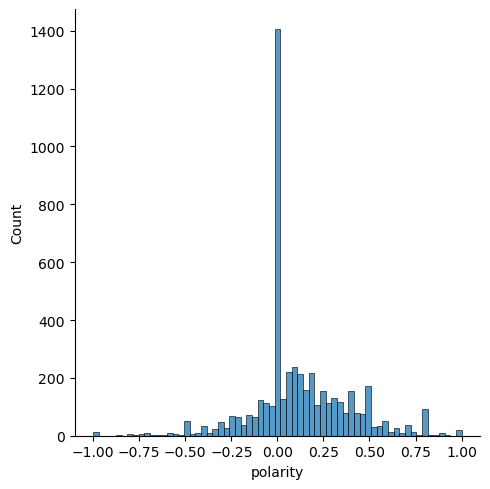

In [62]:
sns.displot(congress_position_subset,         # specify data
            x="polarity") # x-axis label 
plt.show()

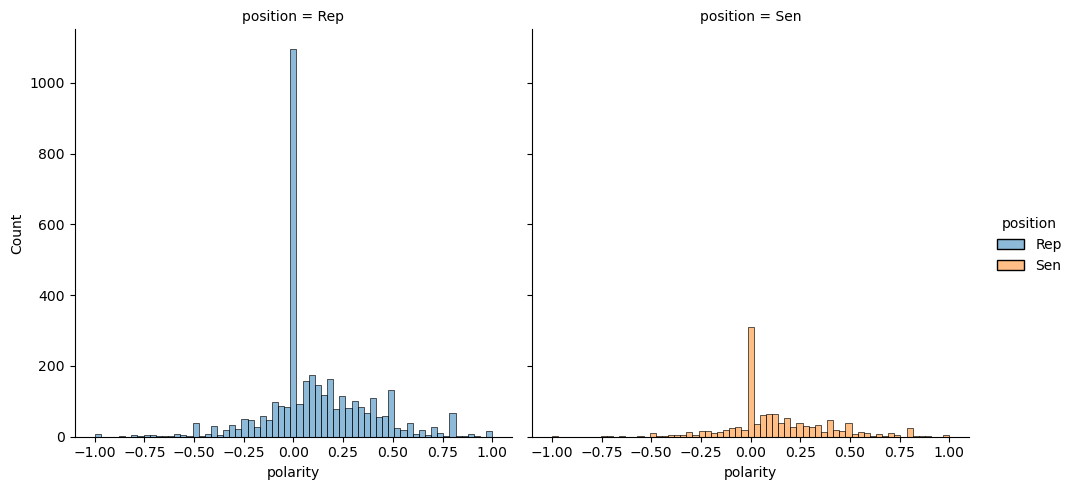

In [63]:
sns.displot(congress_position_subset,             # specify data
            x="polarity",   # x-axis feature
            hue = "position",  # color by loan product
            col = "position")  # color by loan product
plt.show()

In [64]:
congress_position_subset['subjectivity'] =  congress_position_subset['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

/var/folders/yx/f3mndt3d7tbg3g_q0clrd7700000gn/T/ipykernel_398/3443864311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  congress_position_subset['subjectivity'] =  congress_position_subset['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)


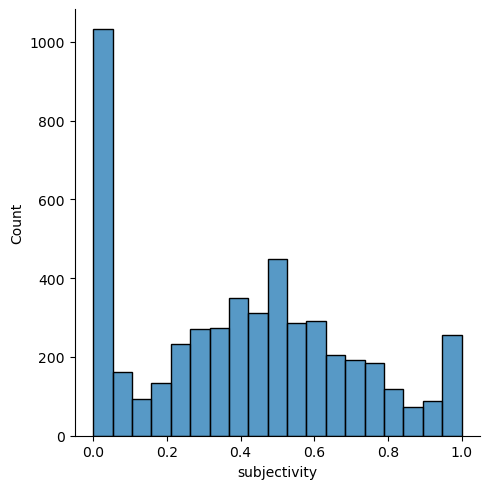

In [65]:
# plot
sns.displot(congress_position_subset,             # specify data
            x="subjectivity") # specify x-axis feature
plt.show()
#FThe democratic party have... 

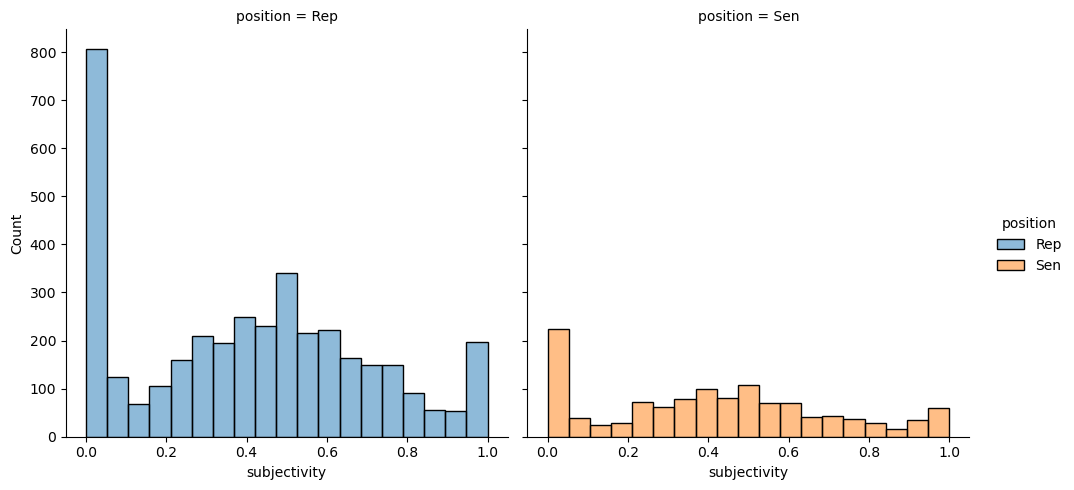

In [66]:
sns.displot(congress_position_subset,             # specify data
            x="subjectivity",   # x-axis feature
            hue = "position",  # color by loan product
            col = "position")  # color by loan product
plt.show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features: Word Counts of Democrat vs Republicans 

In [71]:
# Engineered Features

# find the word count for each document 
# --------
# apply length function to tokens column to count words -- you will need to split the text to count words
congress_party_subset['word_count'] = congress_party_subset['tokens'].apply(lambda x: len(str(x).split()))

# view
congress_party_subset# word count added 

/var/folders/yx/f3mndt3d7tbg3g_q0clrd7700000gn/T/ipykernel_398/661789751.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  congress_party_subset['word_count'] = congress_party_subset['tokens'].apply(lambda x: len(str(x).split()))


,tokens,text,party,polarity,subjectivity,word_count
908961,RepKClark 22 million Americans filed unemploym...,RT @RepKClark 22 million Americans filed for u...,Democrat,0.350000,0.800000,45
175615,Thanks came tonight forum GOPTaxLaw,Thanks to all who came out to tonight’s forum ...,Democrat,0.200000,0.200000,5
64613,RepFilemonVela Dreamers TPS recipients essenti...,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Democrat,0.000000,0.300000,19
783091,HispanicCaucus JoaquinCastrotx TheBlackCaucus ...,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Democrat,0.000000,1.000000,34
553399,Thank NYGovCuomo today face extreme weather sy...,Thank you to @NYGovCuomo for being here today ...,Democrat,0.208333,0.583333,23
...,...,...,...,...,...,...
191471,SenatorBraun May officially ALSAwarenessMonth ...,RT @SenatorBraun May is officially #ALSAwarene...,Democrat,0.500000,0.650000,24
260884,Powerful words today friend colleague SenatorI...,Powerful words today from my friend and collea...,Republican,0.775000,0.587500,22
11727,Ch2KTUU Alaska Senator Dan Sullivan said urged...,RT @Ch2KTUU Alaska Senator Dan Sullivan said h...,Republican,0.050000,0.350000,18
356261,Open schools kyoag Today 38 US Senators includ...,Open the schools. https://twitter.com/kyoag/st...,Republican,0.083333,0.333333,28


### Engineered Text Features: Word Counts of Senate vs Representatives 

In [73]:
# find the word count for each document 
# --------
# apply length function to tokens column to count words -- you will need to split the text to count words
congress_position_subset['word_count'] = congress_position_subset['tokens'].apply(lambda x: len(str(x).split()))

# view
congress_position_subset# word count added 

/var/folders/yx/f3mndt3d7tbg3g_q0clrd7700000gn/T/ipykernel_398/3380803741.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  congress_position_subset['word_count'] = congress_position_subset['tokens'].apply(lambda x: len(str(x).split()))


,tokens,text,position,polarity,subjectivity,word_count
908961,RepKClark 22 million Americans filed unemploym...,RT @RepKClark 22 million Americans filed for u...,Rep,0.350000,0.800000,45
175615,Thanks came tonight forum GOPTaxLaw,Thanks to all who came out to tonight’s forum ...,Rep,0.200000,0.200000,5
64613,RepFilemonVela Dreamers TPS recipients essenti...,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Rep,0.000000,0.300000,19
783091,HispanicCaucus JoaquinCastrotx TheBlackCaucus ...,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Rep,0.000000,1.000000,34
553399,Thank NYGovCuomo today face extreme weather sy...,Thank you to @NYGovCuomo for being here today ...,Rep,0.208333,0.583333,23
...,...,...,...,...,...,...
191471,SenatorBraun May officially ALSAwarenessMonth ...,RT @SenatorBraun May is officially #ALSAwarene...,Sen,0.500000,0.650000,24
260884,Powerful words today friend colleague SenatorI...,Powerful words today from my friend and collea...,Rep,0.775000,0.587500,22
11727,Ch2KTUU Alaska Senator Dan Sullivan said urged...,RT @Ch2KTUU Alaska Senator Dan Sullivan said h...,Sen,0.050000,0.350000,18
356261,Open schools kyoag Today 38 US Senators includ...,Open the schools. https://twitter.com/kyoag/st...,Sen,0.083333,0.333333,28


### Bag-of-words or Tf-idf

In [75]:
# Columns to extract and add
columns_to_add = ['polarity', 'subjectivity', 'word_count']

# 🔹 Merge only the selected columns using a for loop
for col in columns_to_add:
  congress_tweets_subset = congress_tweets_subset.merge(congress_party_subset[['text', col]], on="text", how="left")
# Print updated dataframe
congress_tweets_subset

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tweet_len,tweet_word_count,polarity,subjectivity,word_count
0,908961,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,RT @RepKClark 22 million Americans filed for u...,Pramila Jayapal,Rep,3-Jan-17,9/21/1965,F,...,"1,221,747","1,742,718","1,755,396","1,290,670","[RepKClark, 22, million, Americans, filed, une...",598,74,0.350000,0.800000,45
1,175615,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum ...,John B. Larson,Rep,3-Jan-99,7/22/1948,M,...,"673,215","897,572","905,083","634,892","[Thanks, came, tonight, forum, GOPTaxLaw]",204,15,0.200000,0.200000,5
2,64613,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Nancy Pelosi,Rep,2-Jun-87,3/26/1940,F,...,"4,483,814","8,753,792","7,854,285","4,839,958","[RepFilemonVela, Dreamers, TPS, recipients, es...",267,33,0.000000,0.300000,19
3,783091,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Joaquín Castro,Rep,3-Jan-13,9/16/1974,M,...,"4,685,047","3,877,868","3,308,124","4,569,843","[HispanicCaucus, JoaquinCastrotx, TheBlackCauc...",377,56,0.000000,1.000000,34
4,553399,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today ...,Joseph D. Morelle,Rep,13-Nov-18,4/29/1957,M,...,"2,819,533","4,556,118","4,485,741","2,490,431","[Thank, NYGovCuomo, today, face, extreme, weat...",317,47,0.208333,0.583333,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5065,191471,1.262890e+18,ChrisCoons,2020-05-19T19:56:08-04:00,RT @SenatorBraun May is officially #ALSAwarene...,Chris Coons,Sen,15-Nov-10,9/9/1963,M,...,"185,127","235,603","242,584","165,484","[SenatorBraun, May, officially, ALSAwarenessMo...",295,39,0.500000,0.650000,24
5066,260884,1.202000e+18,AustinScottGA08,2019-12-03T18:11:42-05:00,Powerful words today from my friend and collea...,Austin Scott,Rep,3-Jan-11,12/10/1969,M,...,"2,089,104","1,877,963","1,773,827","2,078,688","[Powerful, words, today, friend, colleague, Se...",395,41,0.775000,0.587500,22
5067,11727,1.215110e+18,SenDanSullivan,2020-01-08T22:26:32-05:00,RT @Ch2KTUU Alaska Senator Dan Sullivan said h...,Dan Sullivan,Sen,3-Jan-15,11/13/1964,M,...,"163,387","116,454","122,640","164,676","[Ch2KTUU, Alaska, Senator, Dan, Sullivan, said...",291,33,0.050000,0.350000,18
5068,356261,1.335220e+18,RandPaul,2020-12-05T08:30:47-05:00,Open the schools. https://twitter.com/kyoag/st...,Rand Paul,Sen,3-Jan-11,1/7/1963,M,...,"1,202,971","628,854","679,370","1,087,190","[Open, schools, kyoag, Today, 38, US, Senators...",524,46,0.083333,0.333333,28


In [76]:
# Keep only rows where 'party' is not 'Independent'. Droping independents from dataset 
congress_tweets_subset = congress_tweets_subset[congress_tweets_subset['party'] != 'Independent']

# Reset index after filtering  
congress_tweets_subset = congress_tweets_subset.reset_index(drop=True)

# Print to verify
print(congress_tweets_subset['party'].value_counts())

party
Democrat      3303
Republican    1733
Name: count, dtype: int64


In [77]:
congress_tweets_subset.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tweet_len,tweet_word_count,polarity,subjectivity,word_count
0,908961,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,RT @RepKClark 22 million Americans filed for u...,Pramila Jayapal,Rep,3-Jan-17,9/21/1965,F,...,"1,221,747","1,742,718","1,755,396","1,290,670","[RepKClark, 22, million, Americans, filed, une...",598,74,0.350000,0.800000,45
1,175615,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum ...,John B. Larson,Rep,3-Jan-99,7/22/1948,M,...,"673,215","897,572","905,083","634,892","[Thanks, came, tonight, forum, GOPTaxLaw]",204,15,0.200000,0.200000,5
2,64613,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Nancy Pelosi,Rep,2-Jun-87,3/26/1940,F,...,"4,483,814","8,753,792","7,854,285","4,839,958","[RepFilemonVela, Dreamers, TPS, recipients, es...",267,33,0.000000,0.300000,19
3,783091,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Joaquín Castro,Rep,3-Jan-13,9/16/1974,M,...,"4,685,047","3,877,868","3,308,124","4,569,843","[HispanicCaucus, JoaquinCastrotx, TheBlackCauc...",377,56,0.000000,1.000000,34
4,553399,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today ...,Joseph D. Morelle,Rep,13-Nov-18,4/29/1957,M,...,"2,819,533","4,556,118","4,485,741","2,490,431","[Thank, NYGovCuomo, today, face, extreme, weat...",317,47,0.208333,0.583333,23


In [78]:
# Frequency Based featurization

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

### LDA & Topic modeling 

## Topics created provide insight into the context of the tweets when mentioning specific presidents and the COVID19 pandemic. The mentioning of George Floyd also reveal the context of police brutality and increased BLM support.Lastly topics show that more preprocessing technqiues is needed to capture check marks and hashtags of specific legislator names 

In [80]:
#
# Latent Dirichlet Allocation (LDA)
# ---------------------------------------
# set seed before everu initialzing function 
# pre-processing
# --------
# create a new data object called X
X = congress_tweets_subset['text']

# initialize tf-idf function and set parameters
tf = TfidfVectorizer(tokenizer = rem_punc_stop,  # specify our function for remove punc and stop words
                     token_pattern = None)       # specify "None" to remove warning. Is this necessary?

# apply tf-idf vectorizer to our data (X)
tfidf_matrix =  tf.fit_transform(X)

# modify the output to be a dense matrix
dense_matrix = tfidf_matrix.todense()

# intitialize LDA model and 
# --------
# initialize LDA and set model parameters
lda = LatentDirichletAllocation(n_components=5, # specify the number of components
                                max_iter=20,    # specify the number of iterations 
                                random_state=0) # set a seed for reproducibility

# fit LDA model to our dense matrix
lda = lda.fit(np.asarray(dense_matrix))

# post-processing
# --------
# get feature names from our tf-idf vector
tf_feature_names = tf.get_feature_names_out()

# print top words 
print_top_words(lda,               # specify model
                tf_feature_names,  # specify feature names vector
                20)                # specify how many words we want to see
 

# now transform our data using the lda model and create a dataframe
topic_dist = lda.transform(tfidf_matrix)
topic_dist_df_dems = pd.DataFrame(topic_dist).reset_index(drop = True)

# view the corresponding tf-idf dataframe with tf-idf values
topic_dist_df_dems


Topic #0:
census statedept secpompeo schiff senbillcassidy sentedcruz impeachment senjohnkennedy azuvanich citgo6c aliriorafael8 vvadell carmenmolinos mariaelenacard4 freecitgo6 complete johncornyn → vp statespeha

Topic #1:
✔ martin jr luther fun confirming ✓ mcgahn uswnt father nonessential professor passover snow engage exact defendfreedom secwilkie peterwelch trip

Topic #2:
de george floyd la el y en para loss catch usnavy que producers merry los mikepence govtimwalz brother mourn pork

Topic #3:
today   need trump people president act help house health covid19 work american congress americans time new bill day families

Topic #4:
track president add select simple attempt processes speaker gopoversight 8 virus chance year oversight pelosi committee attack want election democrats



,0,1,2,3,4
0,0.031330,0.030815,0.030815,0.876226,0.030814
1,0.062916,0.062921,0.062800,0.329397,0.481965
2,0.039981,0.039802,0.039793,0.840631,0.039793
3,0.032340,0.032247,0.380984,0.521680,0.032749
4,0.036689,0.036688,0.036688,0.853232,0.036703
...,...,...,...,...,...
5031,0.037377,0.476480,0.037425,0.411266,0.037452
5032,0.039027,0.355310,0.039792,0.526826,0.039045
5033,0.189851,0.040246,0.040508,0.689671,0.039724
5034,0.035635,0.035640,0.035628,0.857470,0.035627


### Word Embedding Doc2vec

In [82]:
import gensim
from gensim import models
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE

In [83]:
# intitalize label binarizer
lb_style = LabelBinarizer()

# fit transform
y = congress_tweets_subset['party']

# train/test split
train, test = train_test_split(congress_tweets_subset,             # specify dataset
                               test_size=0.2,    # specify test size
                               random_state=42)  # set seed
# view
train.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tweet_len,tweet_word_count,polarity,subjectivity,word_count
4978,614170,1.187000e+18,RepAdams,2019-10-23T09:45:53-04:00,@SenAlexander decided to ignore the needs of #...,Alma Adams,Rep,4-Nov-14,5/27/1946,F,...,"2,362,631","2,189,316","2,178,391","2,270,395","[SenAlexander, decided, ignore, needs, HBCUs, ...",255,38,0.000000,0.000000,25
463,481821,1.322270e+18,JeffFortenberry,2020-10-30T16:26:15-04:00,Received a nice note this morning about how th...,Jeff Fortenberry,Rep,3-Jan-05,12/27/1960,M,...,"495,961","284,494","302,081","475,064","[Received, nice, note, morning, USDA, Free, Sc...",280,44,0.250000,0.668750,28
2369,244176,1.280930e+18,MarioDB,2020-07-08T14:34:12-04:00,RT @JBarsaUSAID The #TIPReport highlights the ...,Mario Diaz-Balart,Rep,3-Jan-03,9/25/1961,M,...,"4,617,886","4,504,975","4,237,756","4,163,447","[JBarsaUSAID, The, TIPReport, highlights, Cast...",327,42,-0.041667,0.063889,23
3194,146412,1.309210e+18,RepThompson,2020-09-24T15:01:58-04:00,RT @RepJudyChu Today we #WearOrangeMasks to ma...,Mike Thompson,Rep,3-Jan-99,1/24/1951,M,...,"4,483,814","8,753,792","7,854,285","4,839,958","[RepJudyChu, Today, WearOrangeMasks, mark, 575...",281,43,0.000000,0.000000,23
2063,946180,1.278710e+18,RepLizCheney,2020-07-02T11:11:55-04:00,RT @westerncaucus 1/2 Child labor is a sad fac...,Liz Cheney,Rep,3-Jan-17,7/28/1966,F,...,"174,419","55,973","69,286","170,962","[westerncaucus, 12, Child, labor, sad, fact, c...",209,34,-0.166667,0.500000,21


In [84]:
# apply tag to each train/test dataset
# ----------

# tag training datatset
congress_train_tagged = train.apply(lambda r: TaggedDocument(words=r['tokens'],
                                                         tags=[r.party]), 
                                axis=1)

# tag testing datatset
congress_test_tagged = test.apply(lambda r: TaggedDocument(words=r['tokens'], 
                                                       tags=[r.party]),
                              axis=1)

# view the first row
congress_train_tagged[0]

TaggedDocument(words=['RepKClark', '22', 'million', 'Americans', 'filed', 'unemployment', '4', 'weeks', 'We', 'need', 'find', 'innovative', 'solutions', 'act', 'fast', 'That', 's', 'I', 'support', 'PaycheckGuaranteeAct', 'cover', '100', 'wages', 'workers', 'earning', '100k', 'ensure', 'workers', 'healthcare', 'politico', 'BREAKING', '52', 'million', 'Americans', 'applied', 'unemployment', 'week', 'In', 'weeks', '22', 'million', 'people', 'seeking', 'jobless', 'benefits'], tags=['Democrat'])

In [85]:
import multiprocessing
from tqdm import tqdm
cores = multiprocessing.cpu_count()
cores

8

In [86]:
model_dbow = Doc2Vec(dm=0,              # training algorithim: distributed bag of words
                     vector_size=300,   # word embedding size
                     negative=5,        # how many negative samples
                     hs=0,              # hierarchical softmax using negative samples
                     min_count=2,       # ignores all words with a total frequency lower than this threshold.
                     sample = 0,        # how much downsampling - 0 means none
                     seed = 1995, 
                     workers=cores - 1) # how many cores will be used - will not be fully reproducible however

# apply to training data
model_dbow.build_vocab([x for x in tqdm(congress_train_tagged.values)])

100%|██████████████████████████████████| 4028/4028 [00:00<00:00, 6690953.07it/s]


In [87]:
for epoch in range(1,30):
    model_dbow.train(utils.shuffle([x for x in tqdm(congress_train_tagged.values)]), 
                     total_examples=len(congress_train_tagged.values), 
                     epochs=epoch)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████████████████████████████| 4028/4028 [00:00<00:00, 9845370.93it/s]


In [88]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

In [89]:
import gensim
from gensim import models
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE

## Word Emedding PCA to visualize 

In [91]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
#def document_vector(word2vec_model, doc)
#doc = [word for word in doc if word in model.vocab]
#return np.mean(model[doc], axis=0)

In [92]:
# embedding based featurization
embedded_model = gensim.models.Word2Vec(congress_tweets_subset ['tokens'],    # specify data - sentences
                               vector_size=100,   # set embedding size at 100
                               window=5,          # max distance between current and predicted word
                               min_count=5,       # ignores words with freq fewer than this threshold
                               sg=0,              # specify Continuous Bag of Words Algorithim
                               alpha=0.025,       # learning rate
                               epochs = 5,        # iterations
                               seed = 1,          # set random seed (same as random_state in sklearn )
                               batch_words=10000, # sample size 
                               workers = 1)       # set cores to 1 to ensure this embeddings are fully reproducible

In [93]:
# return embeddings for specific word
# ----------
print(embedded_model.wv.__getitem__(['community'])) # specify a key word here: "community"

[[-0.27759528  0.4231058   0.12503655 -0.02933425  0.02405104 -1.0262755
   0.52058417  1.3578997  -0.6008357  -0.25604898 -0.27657822 -1.0019141
  -0.25531167  0.49455652 -0.07201632 -0.39776382  0.08187172 -0.79272634
   0.03191767 -1.3671954   0.38354954  0.3710502   0.4528715  -0.41992974
  -0.13860855  0.13798542 -0.6124441  -0.45032856 -0.54973435  0.04101972
   0.7350958   0.0926085   0.39520544 -0.4705991  -0.20059828  0.7724791
  -0.06511217 -0.37828538 -0.3729462  -1.2294049   0.08047336 -0.26171708
  -0.18203382 -0.08844038  0.41318104 -0.31253052 -0.8159964   0.11344866
   0.25149208  0.6169509   0.32111195 -0.42998168 -0.5382129  -0.00971424
  -0.43961042  0.5796037   0.4659031  -0.04042943 -0.43873024  0.39850515
   0.16107883  0.20320326 -0.4204069   0.23409684 -0.5587389   0.50445074
   0.12705834  0.34672186 -0.74174213  0.7470964  -0.57407165  0.40014067
   0.73821616 -0.62932146  0.6256415   0.2955398  -0.05007048 -0.19473311
  -0.73839426  0.2851193  -0.13876726  0.

In [94]:
# return a list of word for which we have calculations
# ----------
words = list(embedded_model.wv.index_to_key)
print(words[0:100])  # print the first 100 words

['I', 'The', ' ', 'We', 'This', 'Trump', 'need', 'people', 'help', 'House', 'COVID19', 'President', 'today', 'work', 'Act', 'health', 'It', 'American', 'Americans', 'Congress', 'Today', 'time', '—', '“', '”', 'bill', 'US', 'support', 'country', 'families', 'Senate', 'care', 'realDonaldTrump', 'workers', 'communities', 'years', 'continue', 'community', 'nt', 'day', 'week', 'new', 'protect', 'like', 'Thank', '️', 'federal', 'working', 'year', '\n \n', 'public', 'Democrats', 'America', 'funding', '–', 'In', 'businesses', 'vote', 'right', 'legislation', 'bipartisan', 'law', 'ensure', 'important', 'If', 'My', 'relief', 'crisis', 'family', 'coronavirus', 'stop', 'pandemic', 'As', 'know', 'lives', 'proud', 'nation', 'safe', 'state', 'fight', 'passed', 'Our', 'provide', 'great', 'women', 'children', 'access', 'government', 'office', 'A', 'million', 'pass', 'honor', 'students', 'That', 'small', 'security', 'He', 'economy', 'There']


In [95]:
# retrieve vectors from trained model
# ----------
X = embedded_model.wv.__getitem__(embedded_model.wv.index_to_key)

In [96]:
# scale the data
# ----------
X_std = StandardScaler().fit_transform(X)

In [97]:
# make a PCA
# ----------
# set n_components to 2 to graph in 2-D
pca = PCA(n_components=2, 
          random_state = 2021)  

# fit and transform the standardized data
# ----------
Y_pca = pca.fit_transform(X_std)

In [98]:
Y_pca.shape

(3940, 2)

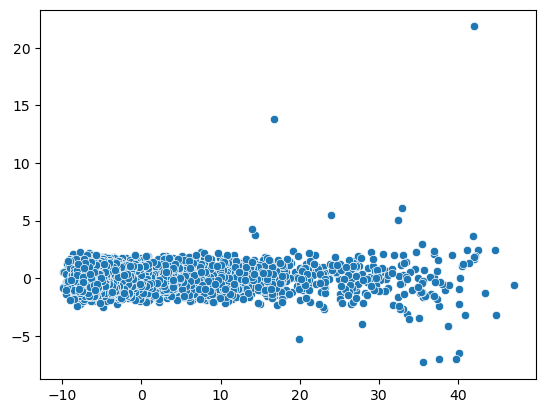

In [99]:
sns.scatterplot(x = Y_pca[:, 0],  # extract all the elements from the first column
                y = Y_pca[:, 1]); # extract all the elements from the second column

In [100]:
!pip install adjustText

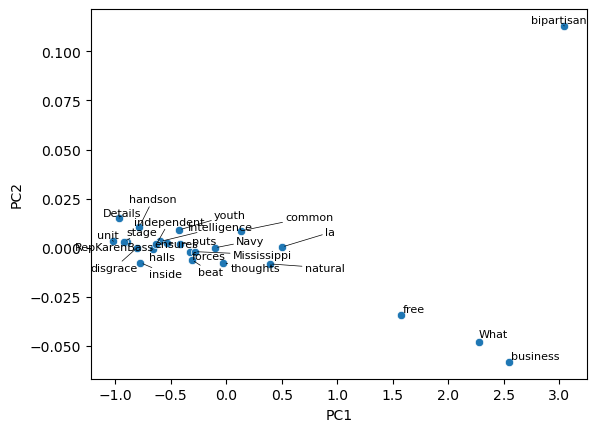

In [101]:
# recreate visualization with points
# ----------

# load libraires
import random
from adjustText import adjust_text

# set seeed
random.seed(10)

# take random sample of 25 word embeddings 
rando = random.sample(list(embedded_model.wv.index_to_key), 25) 

# get embeddings
X1 = embedded_model.wv.__getitem__(rando)

# initalize PCA
pca1 = PCA(n_components=2, 
           random_state=15)

# fit and transform
result = pca1.fit_transform(X1)

# convert to dataframe 
result_df = pd.DataFrame(result,                   # specify data
                         columns = ['PC1', 'PC2'], # specify column names
                         index = rando)            # set index

# create scatterplot
sns.scatterplot(x = 'PC1',         # specify x-axis
                y = 'PC2',         # specify y-axis
                data = result_df)  # specify data

# initialize empty list
texts = []

# append words to list
for word in result_df.index:
    texts.append(plt.text(result_df.loc[word, 'PC1'], 
                          result_df.loc[word, 'PC2'], 
                          word, 
                          fontsize = 8))
    
# adjust plot text to prevent overlapping 
adjust_text(texts, 
            force_text = (0.4,0.4),
            expand = (1.2,1),
            arrowprops = dict(arrowstyle = "-", 
                              color = 'black', 
                              lw = 0.5))

# plot 
plt.show();

In [102]:
result_df.shape

(25, 2)

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [106]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
...

In [107]:
congress_tweets_subset.columns

Index(['index', 'tweet_id', 'screen_name', 'datetime', 'text',
       'name_wikipedia', 'position', 'joined_congress_date', 'birthday',
       'gender', 'state', 'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'tweet_len', 'tweet_word_count',
       'polarity', 'subjectivity', 'word_count'],
      dtype='object')

In [108]:
congress_tweets_subset['party'].head(20)

0       Democrat
1       Democrat
2       Democrat
3       Democrat
4       Democrat
5       Democrat
6     Republican
7       Democrat
8       Democrat
9     Republican
10    Republican
11      Democrat
12    Republican
13    Republican
14    Republican
15      Democrat
16      Democrat
17      Democrat
18    Republican
19      Democrat
Name: party, dtype: object

In [109]:
# Using Engineered Text Features
# --------
# select engineered text features
engineered_features = congress_tweets_subset[['tweet_len','tweet_word_count', 
                            'word_count', 
                            'polarity', 
                            'subjectivity']].reset_index(drop = True)





# create dataframe of tf-idf 
tfidf_df = pd.DataFrame(tfidf_matrix.todense(),                # specify matrix
                        columns = tf.get_feature_names_out())  # set feature names




## By using the TFIDF features as a way to predict if the tweet was authored by a Democrat vs Republican. The confusion matrix revealed a bias in predicting an republican author. High False positive and true positive rates indicating a republican author. 

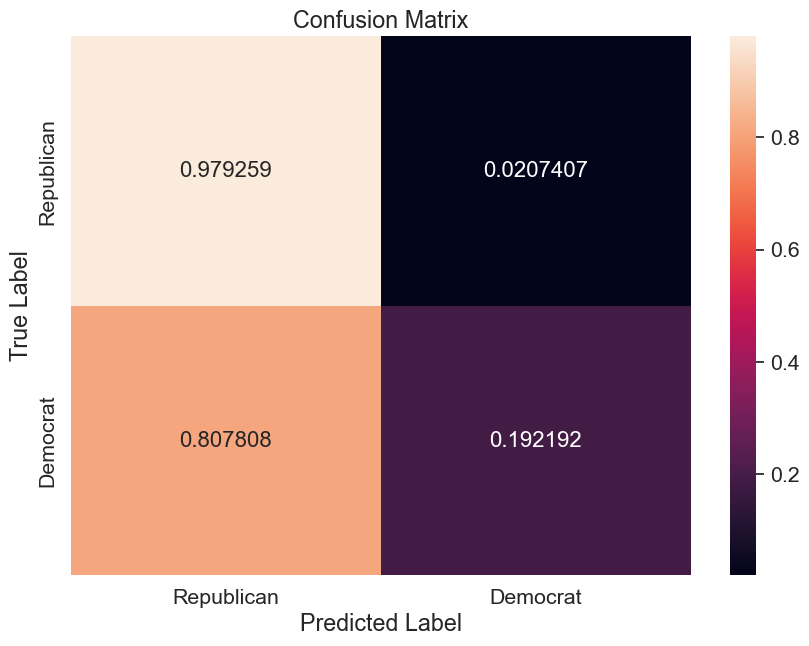

In [111]:
#
# using  Frequency based   Features
# --------------------------------------------------------


# create target dataset

y = congress_tweets_subset['party']


# create features dataset 
# ----------
X = tfidf_df


# split data
# ----------
X_train, X_test, y_train, y_test = train_test_split(X,                # specify features
                                                    y,                # specify labels
                                                    train_size = .80, # specify training data
                                                    test_size=0.20,   # specify test data
                                                    random_state=10)  # set seed

# initalize a logistic regresssion model
# ----------
logit_reg = LogisticRegression(max_iter= 5000) 


# fit the model
# ----------
logit_model = logit_reg.fit(X_train, 
                            y_train)

# predict on test set
# ----------
y_pred = logit_model.predict(X_test)

# create a confusion matrix
# ----------
cf_matrix = confusion_matrix(y_test, 
                             y_pred, 
                             normalize='true')

# create a pandas dataframe from the confusion matrix
# ----------
# create a pandas dataframe from the confusion matrix
# ----------
df_cm = pd.DataFrame(cf_matrix, 
                     range(2),
                     range(2))

# set confusion matrix indices for clarity of visualization
df_cm = df_cm.rename(index=str, 
                         columns={0: "Republican", 
                                  1: "Democrat"})

    # specify confusion matrix index for clarity
df_cm.index = ["Republican", "Democrat"]
    
# figure specifications 
plt.figure(figsize = (10,7)) # set figure size specifications
sns.set(font_scale=1.4)      # set label size
sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## By using the engineered features as a way to predict if the tweet was authored by a Democrat vs Republican. The confusion matrix revealed a complete lack of ability to distinguish between Democrat vs Republican.

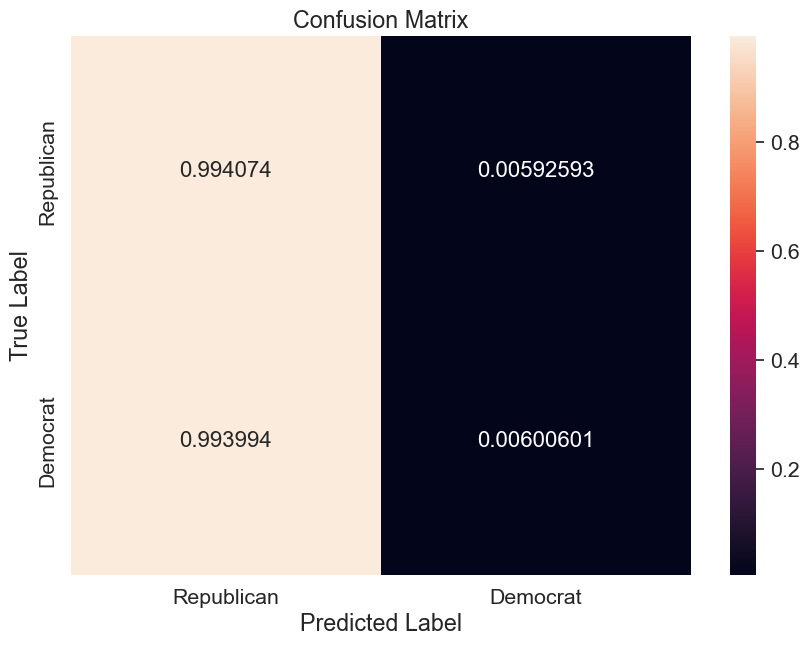

In [113]:
#
# using  engineered   Features
# --------------------------------------------------------


# create target dataset

y = congress_tweets_subset['party']



# create features dataset 
# ----------
X = engineered_features


# split data
# ----------
X_train, X_test, y_train, y_test = train_test_split(X,                # specify features
                                                    y,                # specify labels
                                                    train_size = .80, # specify training data
                                                    test_size=0.20,   # specify test data
                                                    random_state=10)  # set seed

# initalize a logistic regresssion model
# ----------
logit_reg = LogisticRegression(max_iter= 5000) 


# fit the model
# ----------
logit_model = logit_reg.fit(X_train, 
                            y_train)

# predict on test set
# ----------
y_pred = logit_model.predict(X_test)

# create a confusion matrix
# ----------
cf_matrix = confusion_matrix(y_test, 
                             y_pred, 
                             normalize='true')

# create a pandas dataframe from the confusion matrix
# ----------
# create a pandas dataframe from the confusion matrix
# ----------
df_cm = pd.DataFrame(cf_matrix, 
                     range(2),
                     range(2))

# set confusion matrix indices for clarity of visualization
df_cm = df_cm.rename(index=str, 
                         columns={0: "Republican", 
                                  1: "Democrat"})

    # specify confusion matrix index for clarity
df_cm.index = ["Republican", "Democrat"]
    
# figure specifications 
plt.figure(figsize = (10,7)) # set figure size specifications
sns.set(font_scale=1.4)      # set label size
sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## By using the the doc2vec word embeddings features as a way to predict if the tweet was authored by a Democrat vs Republican. The confusion matrix revealed a bias in predicting an republican author. High False positive and true positive rates indicating a republican author. 

In [115]:

lb_style = LabelBinarizer()

# fit transform
y = congress_tweets_subset['party']

# train/test split
train, test = train_test_split(congress_tweets_subset,             # specify dataset
                               test_size=0.2,    # specify test size
                               random_state=42)  # set seed
# view
train.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tweet_len,tweet_word_count,polarity,subjectivity,word_count
4978,614170,1.187000e+18,RepAdams,2019-10-23T09:45:53-04:00,@SenAlexander decided to ignore the needs of #...,Alma Adams,Rep,4-Nov-14,5/27/1946,F,...,"2,362,631","2,189,316","2,178,391","2,270,395","[SenAlexander, decided, ignore, needs, HBCUs, ...",255,38,0.000000,0.000000,25
463,481821,1.322270e+18,JeffFortenberry,2020-10-30T16:26:15-04:00,Received a nice note this morning about how th...,Jeff Fortenberry,Rep,3-Jan-05,12/27/1960,M,...,"495,961","284,494","302,081","475,064","[Received, nice, note, morning, USDA, Free, Sc...",280,44,0.250000,0.668750,28
2369,244176,1.280930e+18,MarioDB,2020-07-08T14:34:12-04:00,RT @JBarsaUSAID The #TIPReport highlights the ...,Mario Diaz-Balart,Rep,3-Jan-03,9/25/1961,M,...,"4,617,886","4,504,975","4,237,756","4,163,447","[JBarsaUSAID, The, TIPReport, highlights, Cast...",327,42,-0.041667,0.063889,23
3194,146412,1.309210e+18,RepThompson,2020-09-24T15:01:58-04:00,RT @RepJudyChu Today we #WearOrangeMasks to ma...,Mike Thompson,Rep,3-Jan-99,1/24/1951,M,...,"4,483,814","8,753,792","7,854,285","4,839,958","[RepJudyChu, Today, WearOrangeMasks, mark, 575...",281,43,0.000000,0.000000,23
2063,946180,1.278710e+18,RepLizCheney,2020-07-02T11:11:55-04:00,RT @westerncaucus 1/2 Child labor is a sad fac...,Liz Cheney,Rep,3-Jan-17,7/28/1966,F,...,"174,419","55,973","69,286","170,962","[westerncaucus, 12, Child, labor, sad, fact, c...",209,34,-0.166667,0.500000,21


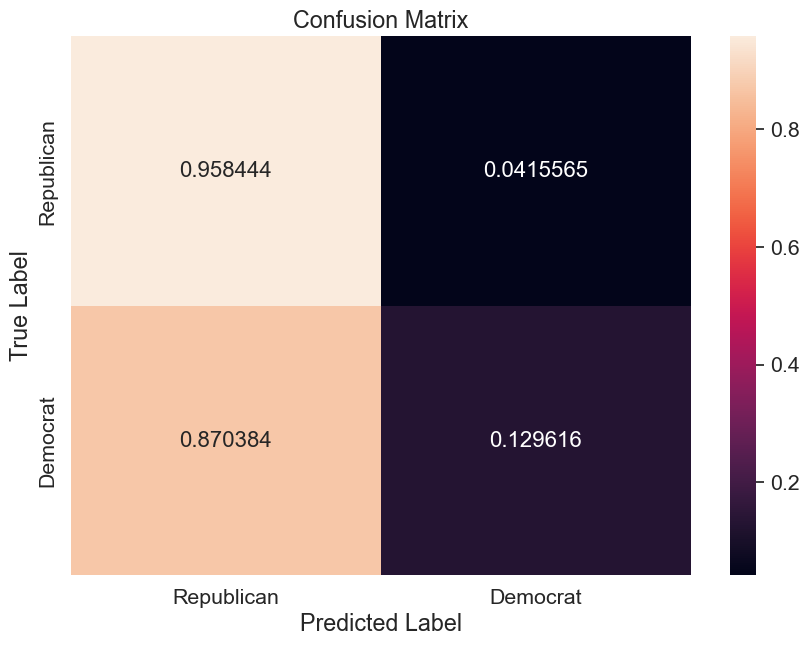

In [116]:
#
## intialize a logit model
# ----------

# split into training
y_train, X_train = vec_for_learning(model_dbow, # specify datasets for split
                                    congress_train_tagged)

# split into testing
y_test, X_test = vec_for_learning(model_dbow,  # specify datasets for split
                                  congress_train_tagged)

# initalize model
logit_reg = LogisticRegression(random_state = 75) # intialize logit model

# fit on training
logit_model = logit_reg.fit(X_train,  # fit to training data
                            y_train)

# predict on test data
y_pred = logit_model.predict(X_test)  # predict on testing data


# confusion matrix
# ----------

# create confusion matrix 
cf_matrix = confusion_matrix(y_test,              # actual
                             y_pred,              # predictions
                             normalize = "true")  # normalize

# create dataframe
df_cm = pd.DataFrame(cf_matrix,   # specify matrix for calculations
                     range(2),
                     range(2))

# set confusion matrix indices for clarity of visualization
df_cm = df_cm.rename(index=str, 
                         columns={0: "Republican", 
                                  1: "Democrat"})

    # specify confusion matrix index for clarity
df_cm.index = ["Republican", "Democrat"]
    
# figure specifications 
plt.figure(figsize = (10,7)) # set figure size specifications
sns.set(font_scale=1.4)      # set label size
sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Repeat process but now predicting the position. 
# Using the TFIDF frequencies (alone) and engineered features (alone) I found a bias in the models to predict senator rathor than representatives. However the least biased classification model that can be used to predict the legislator position seems to be when we apply the doc2vec word embeddings to our model. 

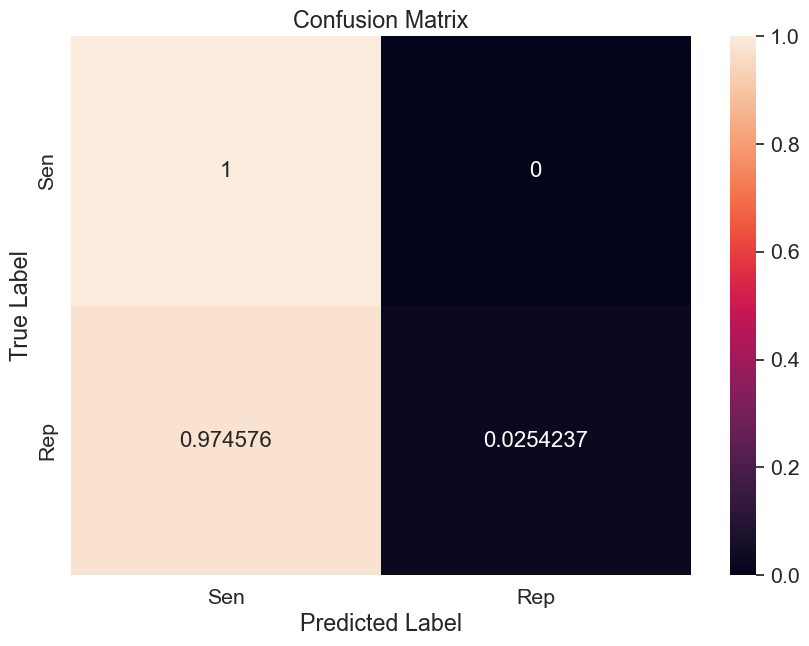

In [118]:
#
# using  Frequency based   Features
# --------------------------------------------------------


# create target dataset

y = congress_tweets_subset['position']


# create features dataset 
# ----------
X = tfidf_df


# split data
# ----------
X_train, X_test, y_train, y_test = train_test_split(X,                # specify features
                                                    y,                # specify labels
                                                    train_size = .80, # specify training data
                                                    test_size=0.20,   # specify test data
                                                    random_state=10)  # set seed

# initalize a logistic regresssion model
# ----------
logit_reg = LogisticRegression(max_iter= 5000) 


# fit the model
# ----------
logit_model = logit_reg.fit(X_train, 
                            y_train)

# predict on test set
# ----------
y_pred = logit_model.predict(X_test)

# create a confusion matrix
# ----------
cf_matrix = confusion_matrix(y_test, 
                             y_pred, 
                             normalize='true')

# create a pandas dataframe from the confusion matrix
# ----------
# create a pandas dataframe from the confusion matrix
# ----------
df_cm = pd.DataFrame(cf_matrix, 
                     range(2),
                     range(2))

# set confusion matrix indices for clarity of visualization
df_cm = df_cm.rename(index=str, 
                         columns={0: "Sen", 
                                  1: "Rep"})

    # specify confusion matrix index for clarity
df_cm.index = ["Sen", "Rep"]
    
    
# figure specifications 
plt.figure(figsize = (10,7)) # set figure size specifications
sns.set(font_scale=1.4)      # set label size
sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

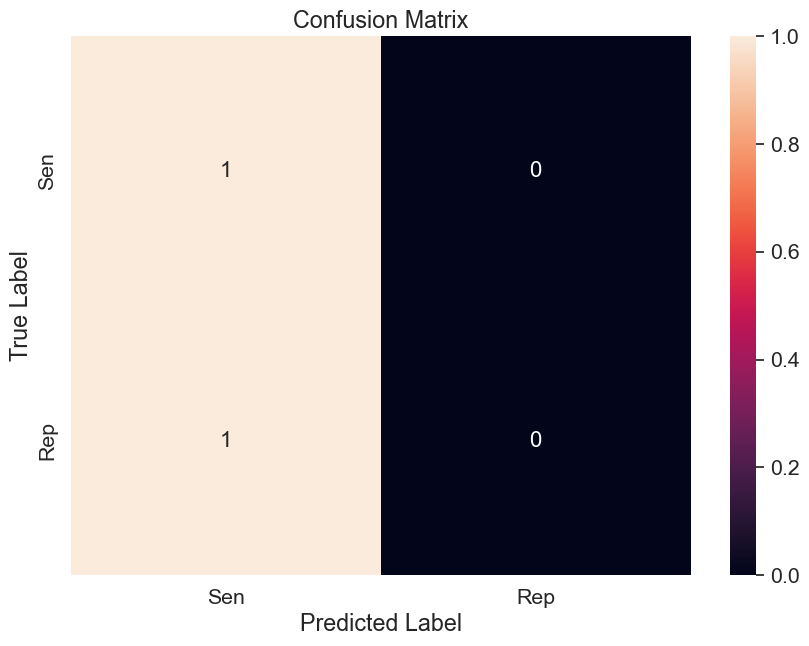

In [119]:
#
# using  engineered   Features
# --------------------------------------------------------


# create target dataset

y = congress_tweets_subset['position']



# create features dataset 
# ----------
X = engineered_features


# split data
# ----------
X_train, X_test, y_train, y_test = train_test_split(X,                # specify features
                                                    y,                # specify labels
                                                    train_size = .80, # specify training data
                                                    test_size=0.20,   # specify test data
                                                    random_state=10)  # set seed

# initalize a logistic regresssion model
# ----------
logit_reg = LogisticRegression(max_iter= 5000) 


# fit the model
# ----------
logit_model = logit_reg.fit(X_train, 
                            y_train)

# predict on test set
# ----------
y_pred = logit_model.predict(X_test)

# create a confusion matrix
# ----------
cf_matrix = confusion_matrix(y_test, 
                             y_pred, 
                             normalize='true')

# create a pandas dataframe from the confusion matrix
# ----------
# create a pandas dataframe from the confusion matrix
# ----------
df_cm = pd.DataFrame(cf_matrix, 
                     range(2),
                     range(2))

# set confusion matrix indices for clarity of visualization
df_cm = df_cm.rename(index=str, 
                         columns={0: "Sen", 
                                  1: "Rep"})

    # specify confusion matrix index for clarity
df_cm.index = ["Sen", "Rep"]
    
# figure specifications 
plt.figure(figsize = (10,7)) # set figure size specifications
sns.set(font_scale=1.4)      # set label size
sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [120]:

lb_style = LabelBinarizer()

# fit transform
y = congress_tweets_subset['position']

# train/test split
train, test = train_test_split(congress_tweets_subset,             # specify dataset
                               test_size=0.2,    # specify test size
                               random_state=42)  # set seed
# view
train.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tweet_len,tweet_word_count,polarity,subjectivity,word_count
4978,614170,1.187000e+18,RepAdams,2019-10-23T09:45:53-04:00,@SenAlexander decided to ignore the needs of #...,Alma Adams,Rep,4-Nov-14,5/27/1946,F,...,"2,362,631","2,189,316","2,178,391","2,270,395","[SenAlexander, decided, ignore, needs, HBCUs, ...",255,38,0.000000,0.000000,25
463,481821,1.322270e+18,JeffFortenberry,2020-10-30T16:26:15-04:00,Received a nice note this morning about how th...,Jeff Fortenberry,Rep,3-Jan-05,12/27/1960,M,...,"495,961","284,494","302,081","475,064","[Received, nice, note, morning, USDA, Free, Sc...",280,44,0.250000,0.668750,28
2369,244176,1.280930e+18,MarioDB,2020-07-08T14:34:12-04:00,RT @JBarsaUSAID The #TIPReport highlights the ...,Mario Diaz-Balart,Rep,3-Jan-03,9/25/1961,M,...,"4,617,886","4,504,975","4,237,756","4,163,447","[JBarsaUSAID, The, TIPReport, highlights, Cast...",327,42,-0.041667,0.063889,23
3194,146412,1.309210e+18,RepThompson,2020-09-24T15:01:58-04:00,RT @RepJudyChu Today we #WearOrangeMasks to ma...,Mike Thompson,Rep,3-Jan-99,1/24/1951,M,...,"4,483,814","8,753,792","7,854,285","4,839,958","[RepJudyChu, Today, WearOrangeMasks, mark, 575...",281,43,0.000000,0.000000,23
2063,946180,1.278710e+18,RepLizCheney,2020-07-02T11:11:55-04:00,RT @westerncaucus 1/2 Child labor is a sad fac...,Liz Cheney,Rep,3-Jan-17,7/28/1966,F,...,"174,419","55,973","69,286","170,962","[westerncaucus, 12, Child, labor, sad, fact, c...",209,34,-0.166667,0.500000,21


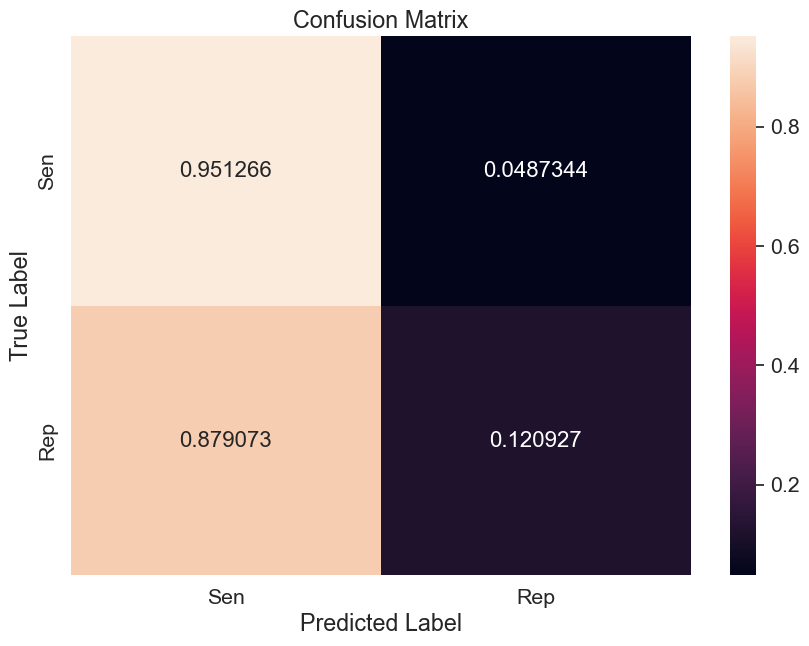

In [121]:
#
## intialize a logit model
# ----------

# split into training
y_train, X_train = vec_for_learning(model_dbow, # specify datasets for split
                                    congress_train_tagged)

# split into testing
y_test, X_test = vec_for_learning(model_dbow,  # specify datasets for split
                                  congress_train_tagged)

# initalize model
logit_reg = LogisticRegression(random_state = 75) # intialize logit model

# fit on training
logit_model = logit_reg.fit(X_train,  # fit to training data
                            y_train)

# predict on test data
y_pred = logit_model.predict(X_test)  # predict on testing data


# confusion matrix
# ----------

# create confusion matrix 
cf_matrix = confusion_matrix(y_test,              # actual
                             y_pred,              # predictions
                             normalize = "true")  # normalize

# create dataframe
df_cm = pd.DataFrame(cf_matrix,   # specify matrix for calculations
                     range(2),
                     range(2))

# set confusion matrix indices for clarity of visualization
df_cm = df_cm.rename(index=str, 
                         columns={0: "Sen", 
                                  1: "Rep"})

    # specify confusion matrix index for clarity
df_cm.index = ["Sen", "Rep"]
    
    
# figure specifications 
plt.figure(figsize = (10,7)) # set figure size specifications
sns.set(font_scale=1.4)      # set label size
sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

 # It is important to note that the confusion matrix' for all models created in this classification section may be influenced by using on a subset of the dataset rather than the complete dataset. Therefore results perhaps were impacted by overfitting. 

### Two Combined Models

In [123]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])

In [124]:
# Non-text features
# --------
# select non-text features
non_text_features = congress_tweets_subset[['gender', 'state', 'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share']]

# get dummies of non-text features
non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)


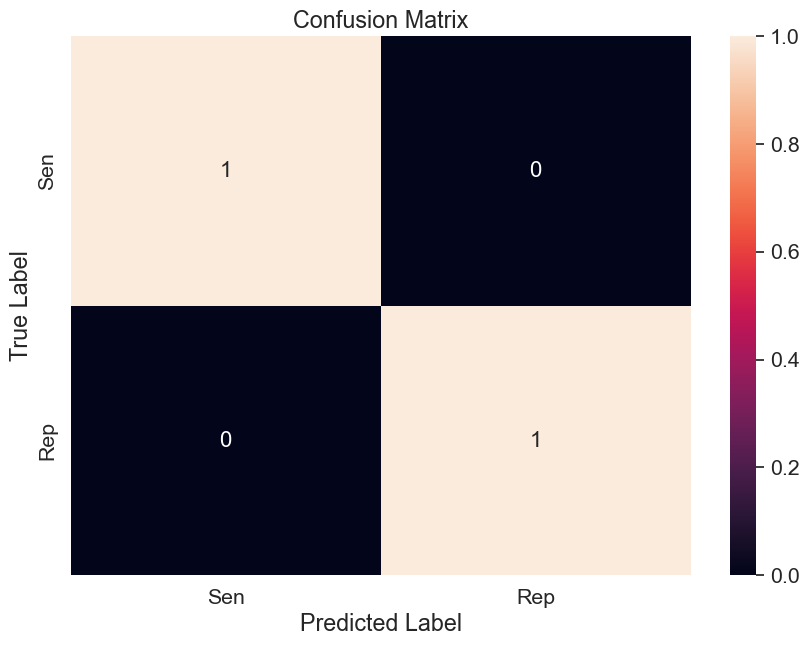

In [125]:


y = congress_tweets_subset['position']



# create features dataset 
# ----------
X = non_text_features_dummies 


# split data
# ----------
X_train, X_test, y_train, y_test = train_test_split(X,                # specify features
                                                    y,                # specify labels
                                                    train_size = .80, # specify training data
                                                    test_size=0.20,   # specify test data
                                                    random_state=10)  # set seed

# initalize a logistic regresssion model
# ----------
logit_reg = LogisticRegression(max_iter= 5000) 


# fit the model
# ----------
logit_model = logit_reg.fit(X_train, 
                            y_train)

# predict on test set
# ----------
y_pred = logit_model.predict(X_test)

# create a confusion matrix
# ----------
cf_matrix = confusion_matrix(y_test, 
                             y_pred, 
                             normalize='true')

# create a pandas dataframe from the confusion matrix
# ----------
# create a pandas dataframe from the confusion matrix
# ----------
df_cm = pd.DataFrame(cf_matrix, 
                     range(2),
                     range(2))

# set confusion matrix indices for clarity of visualization
df_cm = df_cm.rename(index=str, 
                         columns={0: "Sen", 
                                  1: "Rep"})

    # specify confusion matrix index for clarity
df_cm.index = ["Sen", "Rep"]
    
# figure specifications 
plt.figure(figsize = (10,7)) # set figure size specifications
sns.set(font_scale=1.4)      # set label size
sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

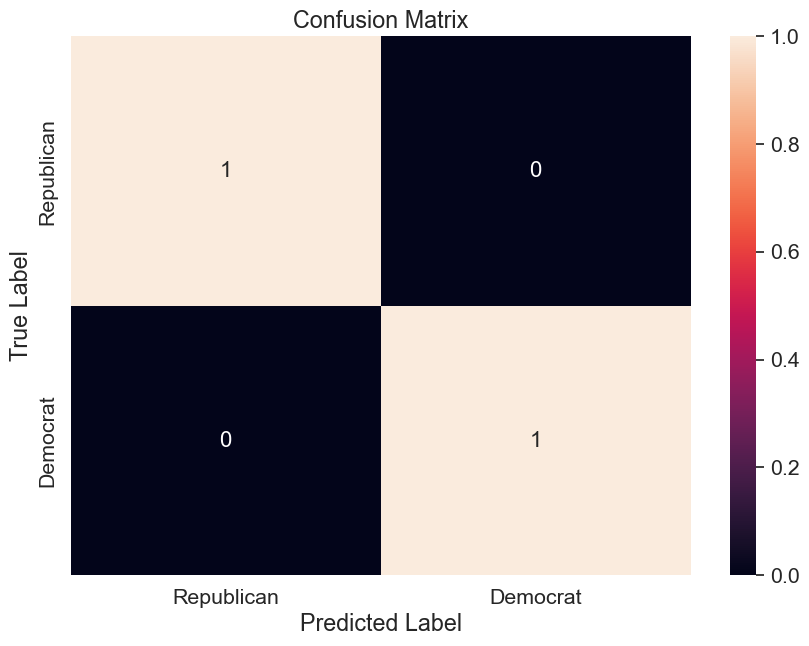

In [126]:


y = congress_tweets_subset['party']



# create features dataset 
# ----------
X = non_text_features_dummies 


# split data
# ----------
X_train, X_test, y_train, y_test = train_test_split(X,                # specify features
                                                    y,                # specify labels
                                                    train_size = .80, # specify training data
                                                    test_size=0.20,   # specify test data
                                                    random_state=10)  # set seed

# initalize a logistic regresssion model
# ----------
logit_reg = LogisticRegression(max_iter= 5000) 


# fit the model
# ----------
logit_model = logit_reg.fit(X_train, 
                            y_train)

# predict on test set
# ----------
y_pred = logit_model.predict(X_test)

# create a confusion matrix
# ----------
cf_matrix = confusion_matrix(y_test, 
                             y_pred, 
                             normalize='true')

# create a pandas dataframe from the confusion matrix
# ----------
# create a pandas dataframe from the confusion matrix
# ----------
df_cm = pd.DataFrame(cf_matrix, 
                     range(2),
                     range(2))

# set confusion matrix indices for clarity of visualization
df_cm = df_cm.rename(index=str, 
                         columns={0: "Republican", 
                                  1: "Democrat"})

    # specify confusion matrix index for clarity
df_cm.index = ["Republican", "Democrat"]
    
# figure specifications 
plt.figure(figsize = (10,7)) # set figure size specifications
sns.set(font_scale=1.4)      # set label size
sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [127]:
# more pre-processing 
# --------

dataframes = [non_text_features_dummies,
             model_dbow,congress_train_tagged]


# create a list of labeles based on the objects created above
featurization_technique = ['Non-Text + Doc2vec']
y = congress_tweets_subset['party']

/var/folders/yx/f3mndt3d7tbg3g_q0clrd7700000gn/T/ipykernel_398/445443432.py:22: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_train.ravel()) # specify label data --- don't forget to ravel the label dataset


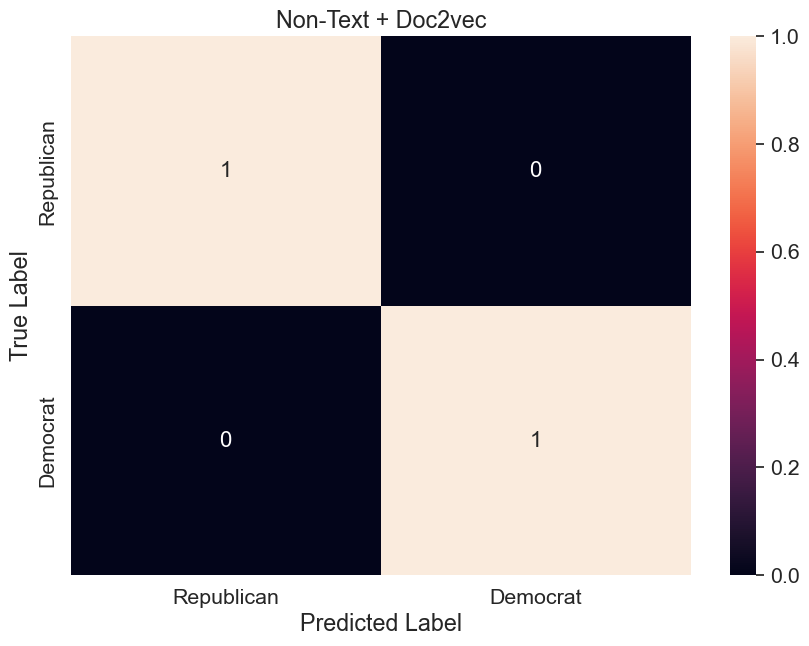

In [128]:
# loop over each dataframe, apply a logit classification model, and create a confusion matrix
# --------
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    # changing column names to strings because some are integer
    dataframe.columns = dataframe.columns.astype(str) 
    
    # split data
    # ----------
    X_train, X_test, y_train, y_test = train_test_split(dataframe,         # specify features
                                                        y,                 # specify labels
                                                        train_size = .80,  # specify train split of 80%
                                                        test_size=0.20,    # specify test split of 20%
                                                        random_state = 10) # set seed for reproducibility
    # apply Logit model 
    # ----------
    # initalize Logit model 
    logit_reg = LogisticRegression() # set max_iter = 500

    # fit the model to our data
    logit_model = logit_reg.fit(X_train,         # specify feature data
                                y_train.ravel()) # specify label data --- don't forget to ravel the label dataset

    # predict on test set
    y_pred = logit_model.predict(X_test)
    
    # create a confusion matrix
    # ----------
    cf_matrix = confusion_matrix(y_test,             # specify test
                                 y_pred,             # specify predicted
                                 normalize = "true") # normalize

    # create a pandas dataframe from the confusion matrix for visualization 
    df_cm = pd.DataFrame(cf_matrix,          # specify cf_matrix from which to create dataframe 
                         range(2), range(2)) # set 2 by 2 

   # set confusion matrix indices for clarity of visualization
    df_cm = df_cm.rename(index=str, 
                         columns={0: "Republican", 
                                  1: "Democrat"})

    # specify confusion matrix index for clarity
    df_cm.index = ["Republican", "Democrat"]
    
    # figure specifications 
    plt.figure(figsize = (10,7)) # set figure size specifications
    sns.set(font_scale=1.4)      # set label size
    sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

Standard preprocessing techniques need to be further customized due to the unique content within specific corpus availiable online. For instance, textual corpus extracted from social media sources often contain hashtags, misspellings, emojis, slang, etc. If we rely on only stop words and rem punc functions,our dataset will still contain many of these elements. This can potentially skew our word count, tweet lengths, polarity and subjectivity scores as some packages may not be as nuianced to capture the meaning of such elements. 

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

Overall, when comparing the polarity and subjectivty of the Democrats and Republicans tweets it appear that Democrats often posted tweets that were less subjective ( i.e based on facts and less of personal opinion) and more frequentlty to have a positive and netural sentiment value. As we compare the sentiment analysis results for Senators and Representatives it appears that Reps are less subjective and frequently post neutral tweets in comparison to Senators.

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

This is a valuable approach because at first glance our unsupervised learning approaches show a slight difference in communication between Democrats and Republicans & Senators and Representatives. However when we apply supervised learning algorithms such as those applied in the classification section we see that tweets across parties and position become less indisguishable.  When we use TFIDF and LDA topic modeling we reduce the features of a dataset, thus by using a supervised learning algorithm such as logistic regression we can examine if these features selcted are relevant to predict known outcomes. 

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

The non text only and text & non text features performed the best to predict party and position.   The non text features are formatted and structured in the same way throughout the dataset. Textual features are important because they allude to the semantics and context of a specific tweet, however in large datasets it can become difficult to capture all unqiue elements and standardize the rows with similar formatting.

## Question 9

In [139]:
#install the transformers library
!pip install transformers
!pip install transformers torch tensorflow

In [140]:
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
# from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
!pip install tf-keras

In [141]:
from transformers import pipeline, set_seed
# Here, 'text-generation' tells the pipeline to create a text generation model, and model='gpt2'
# specifies that you want to use the GPT-2 model for this task.
generator = pipeline('text-generation', model='gpt2')

Device set to use mps:0


In [142]:
set_seed(100)
input_text = "How do Democrats and Republicans differ in their social media communication?"
# specifying the maximum length of the output, and the number of different sequences you want
output = generator(input_text, max_length=50, num_return_sequences=5)
for result in output:
    print(result['generated_text'])
    print("----")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


How do Democrats and Republicans differ in their social media communication?

Republicans have a better track record than Democrats, at least in social media. Republicans have the most social media in terms of social media followers, whereas Democrats do not have any. The
----
How do Democrats and Republicans differ in their social media communication? Is there a pattern, and if so, how do they relate among their constituencies?

The Washington Post reported that both Democrats and Republicans use online forums, such as Facebook or Twitter or
----
How do Democrats and Republicans differ in their social media communication?

Democrats are often accused of having an insular, post-Obama agenda and the Republican Party is often seen as a social-media hub where members can communicate online rather than online with
----
How do Democrats and Republicans differ in their social media communication?

The latest research suggests partisan media influence is not likely to change the outcome of pr

In [246]:
set_seed(100)
input_text = "How do Senators and Representatives  differ in their social media communication?"
# specifying the maximum length of the output, and the number of different sequences you want
output = generator(input_text, max_length=50, num_return_sequences=5)
for result in output:
    print(result['generated_text'])
    print("----")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


How do Senators and Representatives  differ in their social media communication?

You probably don't realize that Senator and Representative Twitter accounts appear to share a lot, but most of the top lawmakers do it on the social networking sites such as Facebook. Also
----
How do Senators and Representatives  differ in their social media communication? Is there a pattern, and if so, how do they relate to each of the public in the United States and in the United Kingdom?

This article examines three issues: 1
----
How do Senators and Representatives  differ in their social media communication?

Sen. Elizabeth Warren (D-MA), who has been an outspoken critic of President Barack Obama's administration on Twitter, said Sen. Elizabeth Warren "has said that she hasn
----
How do Senators and Representatives  differ in their social media communication?

Senators and Representatives have had different social media strategies and social media tools from previous generations. Senator Bill Nelson